In [ ]:
import pandas as pd

df_ae = pd.read_csv('/content/drive/MyDrive/differential_learning/gait_ae_dataset.csv')
df_dtw = pd.read_csv('/content/drive/MyDrive/differential_learning/subject_dtw_scores.csv')
df_for = pd.read_csv('/content/drive/MyDrive/differential_learning/subject_forecast_scores.csv')

df_ae.drop(columns=['Unnamed: 0'], inplace=True)

df_ae.head()

subject          trial  reconstruction_error  learning_index
0     S02  S02_0002_Gait              0.135647        0.018941
1     S02  S02_0003_Gait              0.153889        0.018941
2     S02  S02_0004_Gait              0.101571        0.018941
3     S02  S02_0005_Gait              0.115353        0.018941
4     S02  S02_0006_Gait              0.158526        0.018941

In [ ]:
df_dtw.head()

subject_id  final_dtw                                          dtw_curve
0           1  30.942326  [22.044224474928342, 18.935448204400018, 20.67...
1           2   0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2           3   0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3           4  34.392516  [19.789006422273815, 21.55911359912716, 24.202...
4           5   0.000000  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

In [ ]:
df_for.head()

subject_id    real_slope  pred_slope  slope_gap
0           1  5.269888e-03    0.001819   0.003451
1           2  4.899321e-08   -0.000169   0.000169
2           3 -1.897640e-08   -0.000169   0.000169
3           4 -1.340096e-02   -0.001194   0.012207
4           5 -1.051566e-18   -0.000169   0.000169

In [ ]:
import ast

subject_data = {}

# 1. Loop through unique subject IDs
subject_ids = df_ae["subject"].unique()

for subject_id in subject_ids:
    # Subject ID might be a string like "S48"
    subject_str = subject_id
    subject_num = int(subject_str[1:])  # strip 'S' and cast to int

    # AE values
    ae_subset = df_ae[df_ae["subject"] == subject_id]
    reconstruction_error = ae_subset["reconstruction_error"].tolist()
    ae_delta = ae_subset["learning_index"].iloc[0]  # same for all trials

    # Forecasting
    forecast_row = df_for[df_for["subject_id"] == subject_num]
    if not forecast_row.empty:
        real_slope = forecast_row["real_slope"].iloc[0]
        pred_slope = forecast_row["pred_slope"].iloc[0]
        slope_gap  = forecast_row["slope_gap"].iloc[0]
    else:
        real_slope = None
        pred_slope = None
        slope_gap  = None


    # DTW
    dtw_row = df_dtw[df_dtw["subject_id"] == subject_num]
    if not dtw_row.empty:
      final_dtw = dtw_row["final_dtw"].iloc[0]
      dtw_curve = dtw_row["dtw_curve"].iloc[0]
    else:
        final_dtw = None
        dtw_curve = None

    if isinstance(dtw_curve, str):
      try:
          dtw_curve = ast.literal_eval(dtw_curve)
      except Exception as e:
          print(f"⚠️ Failed to parse dtw_curve for subject {subject_id}: {e}")
          dtw_curve = None

    # Compose dictionary
    subject_data[subject_id] = {
        "autoencoder": {
            "reconstruction_error": reconstruction_error,
            "ae_delta": ae_delta
        },
        "forecasting": {
            "real_slope": real_slope,
            "pred_slope": pred_slope,
        },
        "dtw": {
            "final_dtw": final_dtw,
            "dtw_curve": dtw_curve
        }
    }


In [ ]:
def generate_llm_prompt_narrative(sid, subject_info, agai_score):
    ae = subject_info.get("autoencoder", {})
    forecast = subject_info.get("forecasting", {})
    dtw = subject_info.get("dtw", {})

    rec_errors = ae.get("reconstruction_error", [])
    variability_index = ae.get("ae_delta", None)

    real_slope = forecast.get("real_slope", None)
    pred_slope = forecast.get("pred_slope", None)

    final_dtw = dtw.get("final_dtw", None)
    dtw_curve = dtw.get("dtw_curve", [])

    prompt = f"""You are an expert in AI-assisted motor adaptation analysis.

For the following subject, you are provided with outputs from three computational models characterizing short-term gait variability across 20 consecutive trials. The subject was not exposed to any intervention or feedback. Your role is to produce a narrative summary of the subject's adaptation profile, interpreting the composite adaptation index and model-specific findings.

A composite **Acute Gait Adaptation Index (AGAI)** has been computed as a reference metric, integrating:
- 40% Autoencoder-based changes in movement reconstruction error,
- 30% Dynamic Time Warping (DTW) distance evolution across trials,
- 30% Prediction consistency of a Transformer model between real and forecasted trial-wise trends.

---

🔹 **Acute Gait Adaptation Index (AGAI)**: {round(agai_score, 4)}
- *Interpretation: Higher AGAI indicates greater short-term motor variability/adaptation across repeated trials.*

---

🔹 **Autoencoder**:
- Trial-wise reconstruction errors:
  {rec_errors}
- Variability index (error delta from first to last trial): {round(variability_index, 5) if variability_index is not None else 'N/A'}

🔹 **Forecasting Transformer**:
- Real slope of gait feature evolution: {round(real_slope, 5) if real_slope is not None else 'N/A'}
- Predicted slope from model: {round(pred_slope, 5) if pred_slope is not None else 'N/A'}
- Gap between real and predicted slopes: {round(abs(real_slope - pred_slope), 5) if (real_slope is not None and pred_slope is not None) else 'N/A'}

🔹 **Dynamic Time Warping (DTW)**:
- Final DTW distance from trial 1 to trial 20: {round(final_dtw, 2) if final_dtw is not None else 'N/A'}
- DTW curve over trials:
  {dtw_curve}

---

📌 **Please provide a concise narrative analysis summarizing:**
- The subject’s overall short-term motor adaptation profile as reflected by the AGAI and supporting model outputs.
- Which computational model(s) contributed most to your assessment.
- Any notable trends or unique features in the trial-wise data (e.g., pronounced fluctuations, consistent stability, or mixed patterns).

**Do NOT provide a numerical variability score or rating.** Focus on an interpretive, clinician-oriented summary highlighting the adaptation or stability profile observed.

"""

    return prompt

In [ ]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get('OPENAI_API_KEY'))

def call_llm_api(prompt):
    response = client.chat.completions.create(
        model="gpt-4o",
        messages=[
            {
                "role": "system",
                "content": (
                    "You are an expert in AI-assisted motor adaptation analysis. "
                    "Your sole role is to generate concise, clinician-oriented narrative explanations. "
                    "Evaluate the subject's adaptation profile based on the provided outputs from three computational models—"
                    "Autoencoder error changes, forecasting slope differences, and DTW-based trajectory similarity—"
                    "and the composite Acute Gait Adaptation Index (AGAI). "
                    "Summarize the main patterns of adaptation or stability, highlight which model(s) contributed most to your interpretation, "
                    "and mention any notable trends in the trial-wise data (e.g., fluctuations, stability, or mixed features). "
                    "Do NOT provide or invent any numerical variability or adaptation score. "
                    "Your output should be strictly narrative, intended to support clinicians or researchers in understanding short-term motor adaptation profiles."
                )
            },
            {"role": "user", "content": prompt}
        ],
        temperature=0.0,
        max_tokens=700
    )
    return response.choices[0].message.content

# Differential Learning Index for Clustering, Ranking, and Tables

In [ ]:
def compute_agai(subject_data, weights=(0.4, 0.3, 0.3)):
    """
    Computes the Acute Gait Adaptation Index (AGAI) for each subject.

    Parameters:
    - subject_data: dict
        Per-subject dictionary with keys "autoencoder", "dtw", and "forecasting".
        Each contains sub-dictionaries or lists with:
            - "reconstruction_error": list of AE errors across trials
            - "final_dtw": final DTW distance (first vs. last trial)
            - "real_slope", "pred_slope": actual and predicted trend slopes (forecast)
    - weights: tuple (w_ae, w_dtw, w_forecast)
        Default (0.4, 0.3, 0.3): AE, DTW, Forecast

    Returns:
    - agai_scores: dict {subject_id: AGAI score (float)}
        Higher AGAI reflects greater adaptation/variability (not direct learning).
    """
    import numpy as np
    from sklearn.preprocessing import MinMaxScaler

    ae_deltas = []
    dtw_vals = []
    forecast_gaps = []
    subjects = []

    for sid, data in subject_data.items():
        ae = data.get("autoencoder", {})
        dtw = data.get("dtw", {})
        forecast = data.get("forecasting", {})

        rec = ae.get("reconstruction_error", [])
        if not rec or len(rec) < 2:
            continue  # skip incomplete subjects

        delta_ae = rec[0] - rec[-1]  # Change in error; direction may reflect drift/adaptation
        dtw_final = dtw.get("final_dtw", None)
        if isinstance(dtw_final, (list, np.ndarray)):
            dtw_final = float(dtw_final[0])

        real = forecast.get("real_slope", None)
        pred = forecast.get("pred_slope", None)

        if None in [real, pred, dtw_final, delta_ae]:
            continue  # Skip subject if any value is missing

        gap = abs(real - pred)

        ae_deltas.append(delta_ae)
        dtw_vals.append(dtw_final)
        forecast_gaps.append(gap)
        subjects.append(sid)

    # Normalize (MinMax)
    scaler = MinMaxScaler()
    ae_norm = scaler.fit_transform(np.array(ae_deltas).reshape(-1, 1)).flatten() ** 2
    dtw_norm = scaler.fit_transform(np.array(dtw_vals).reshape(-1, 1)).flatten()
    forecast_norm = 1 - scaler.fit_transform(np.array(forecast_gaps).reshape(-1, 1)).flatten()

    # Weighted sum for AGAI
    w_ae, w_dtw, w_forecast = weights
    agai_scores = {}
    for i, sid in enumerate(subjects):
        score = (
            w_ae * ae_norm[i] +
            w_dtw * dtw_norm[i] +
            w_forecast * forecast_norm[i]
        )
        agai_scores[sid] = round(score, 4)

    return agai_scores

## Subjects Classification

In [ ]:
agai = compute_agai(subject_data)
sorted_agai = dict(sorted(agai.items(), key=lambda x: x[1], reverse=True))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_subject_adaptation_panel(subject_id, subject_info, agai_score=None, llm_summary=None):
    ae = subject_info["autoencoder"]
    dtw = subject_info["dtw"]
    forecast = subject_info["forecasting"]

    rec = ae["reconstruction_error"]
    dtw_curve = dtw["dtw_curve"]
    real_slope = forecast["real_slope"]
    pred_slope = forecast["pred_slope"]

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    # (a) AE curve
    axs[0].plot(rec, marker='o')
    axs[0].set_title("AE Reconstruction Error Across Trials")
    axs[0].set_xlabel("Trial")
    axs[0].set_ylabel("Reconstruction Error")
    axs[0].text(-0.12, 1.08, "(a)", transform=axs[0].transAxes, fontsize=16, fontweight='bold', va='top')

    # (b) DTW curve
    axs[1].plot(dtw_curve, marker='x', color='green')
    axs[1].set_title("DTW Distance vs. First Trial")
    axs[1].set_xlabel("Trial")
    axs[1].set_ylabel("DTW Distance")
    axs[1].text(-0.12, 1.08, "(b)", transform=axs[1].transAxes, fontsize=16, fontweight='bold', va='top')

    # (c) Forecast slope
    axs[2].bar(["Actual Slope", "Predicted Slope"], [real_slope, pred_slope], color=["blue", "orange"])
    axs[2].set_title("Forecast Slope Comparison")
    axs[2].axhline(0, color='gray', linestyle='--')
    axs[2].set_ylabel("Slope")
    axs[2].text(-0.12, 1.08, "(c)", transform=axs[2].transAxes, fontsize=16, fontweight='bold', va='top')

    # Overall title
    title = f"Subject {subject_id} | AGAI (Adaptation Index): {agai_score if agai_score is not None else 'N/A'}"
    fig.suptitle(title, fontsize=16, fontweight='bold')

    # Optional: Annotate LLM summary
    if llm_summary is not None:
        plt.figtext(0.5, -0.08, f"LLM Summary: {llm_summary}", wrap=True, ha='center', fontsize=12)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

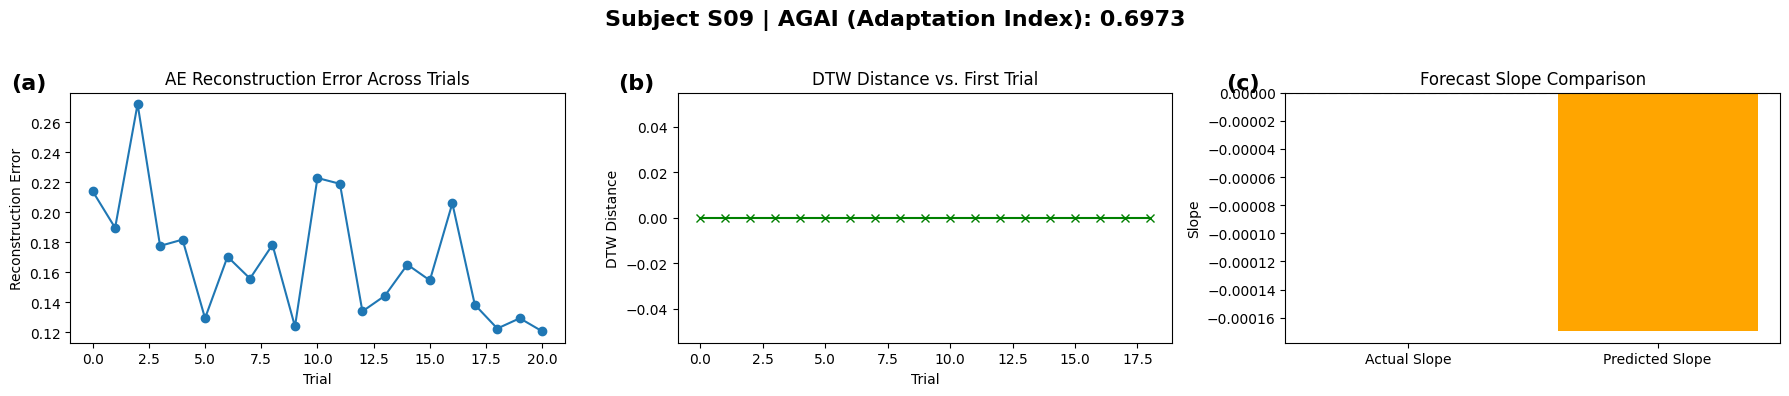

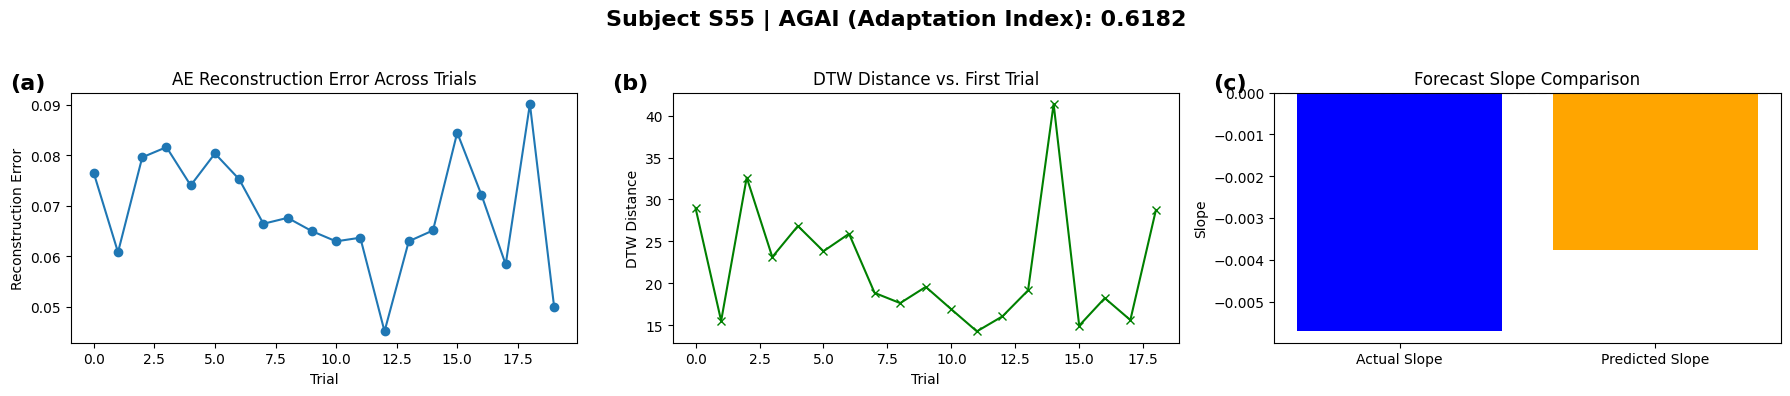

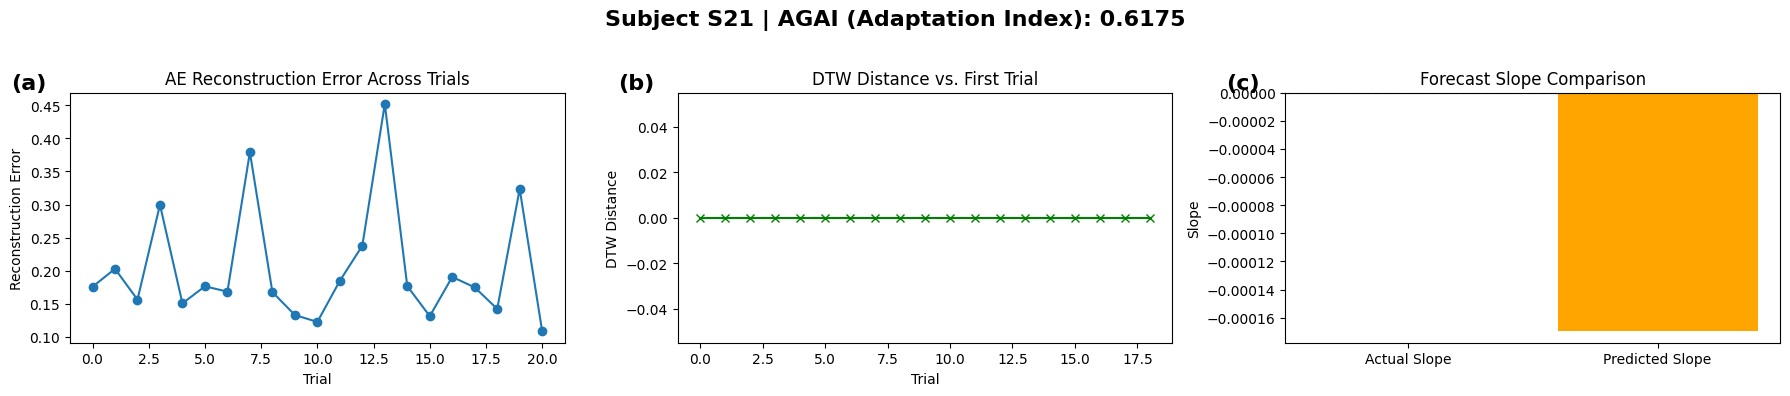

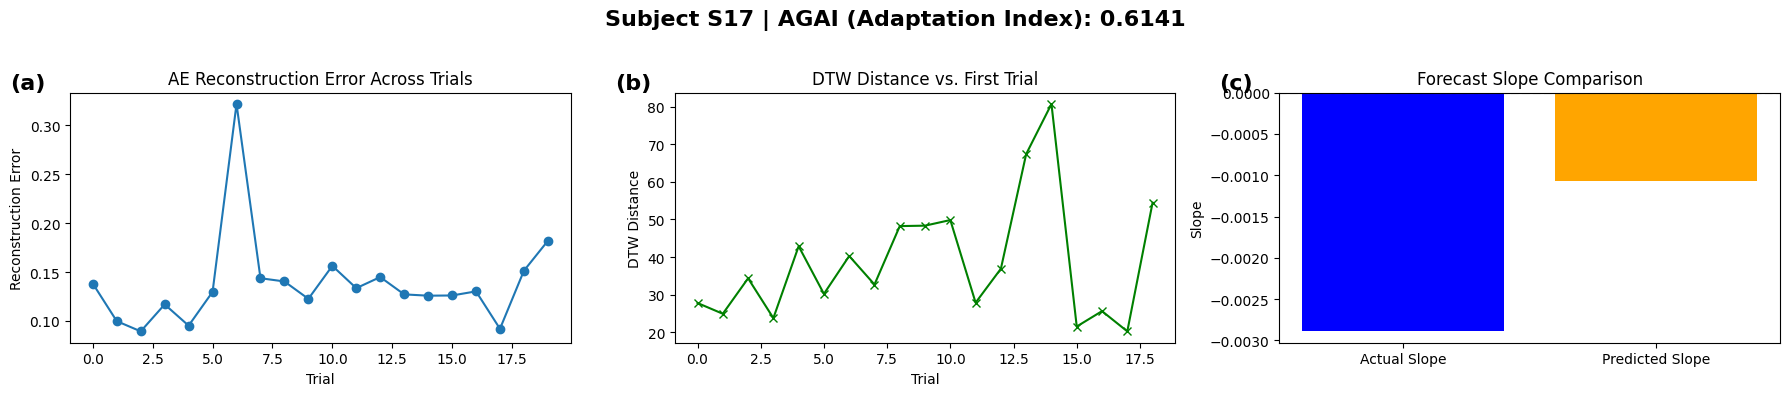

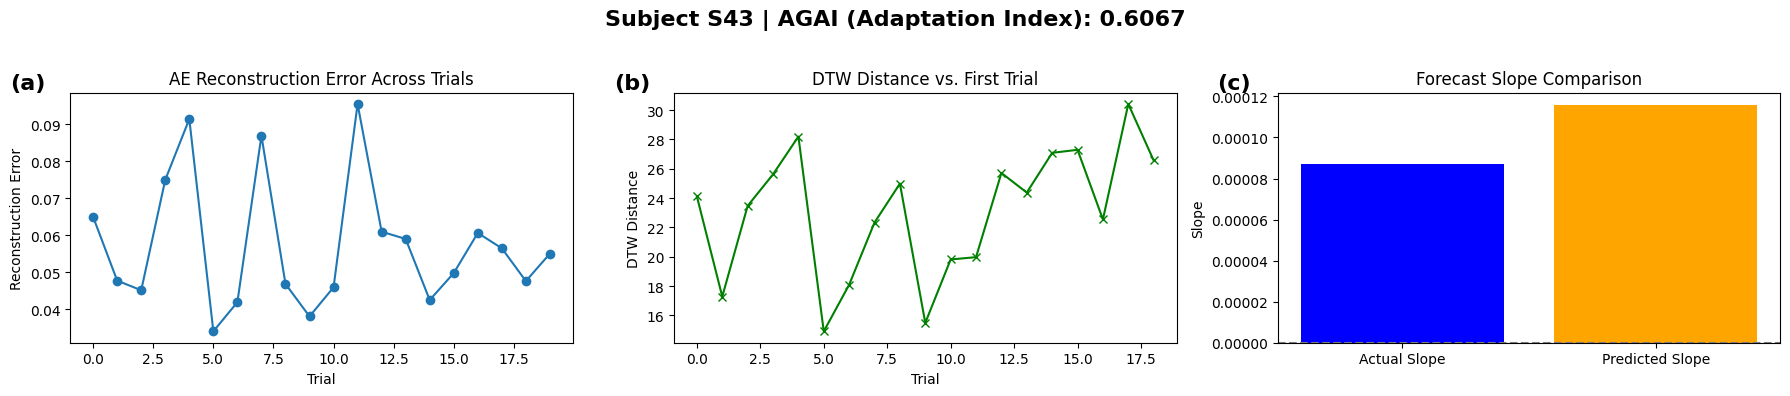

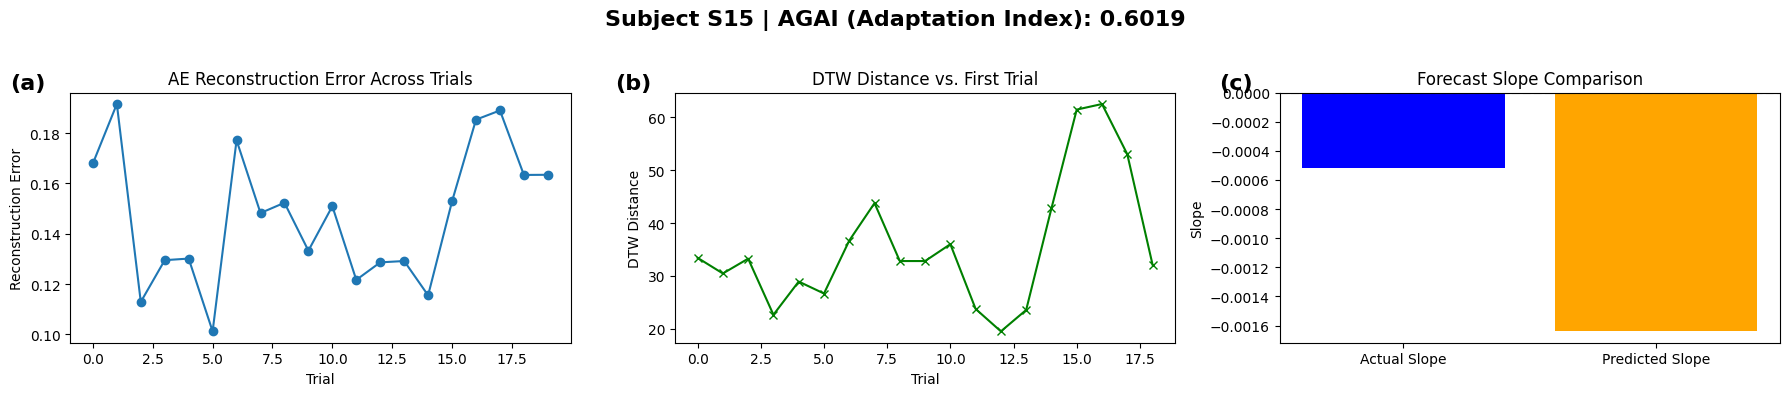

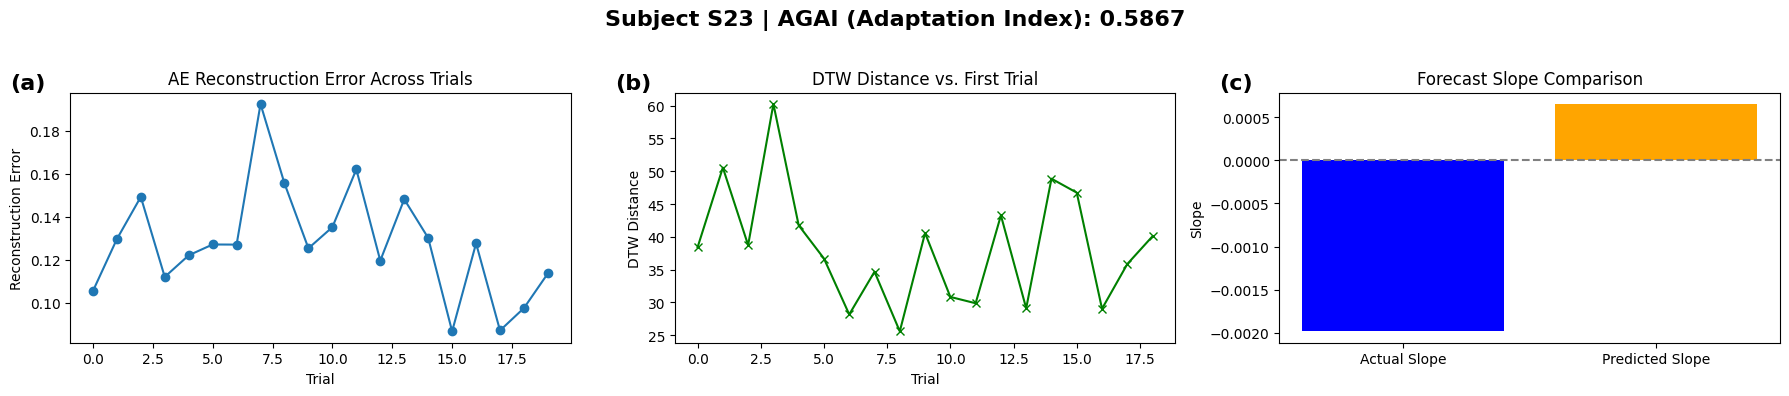

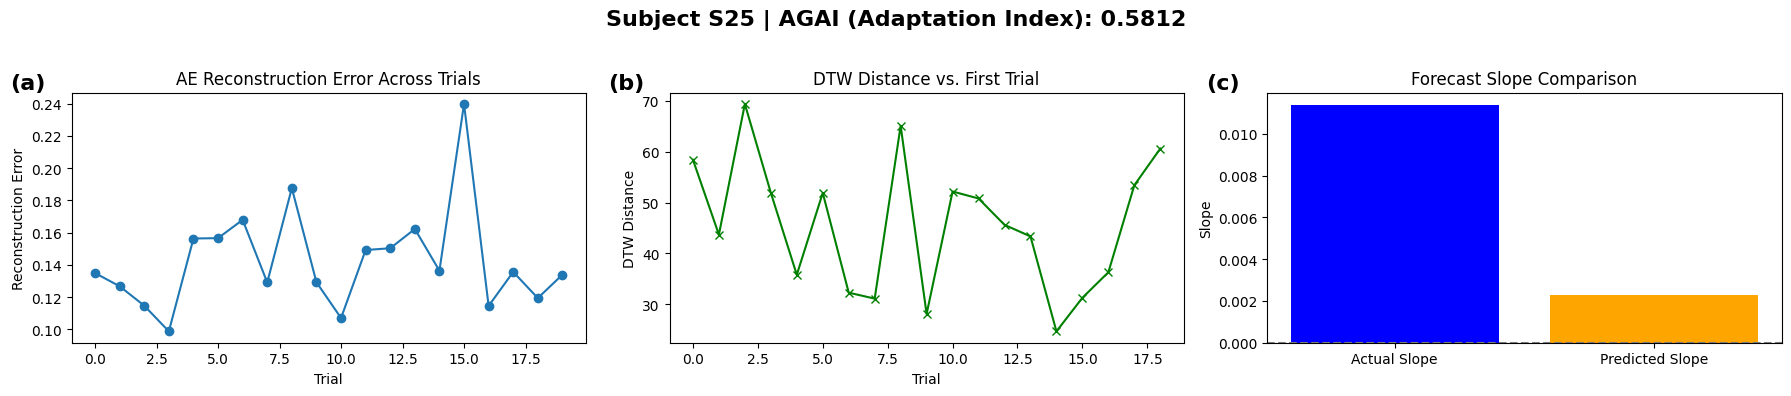

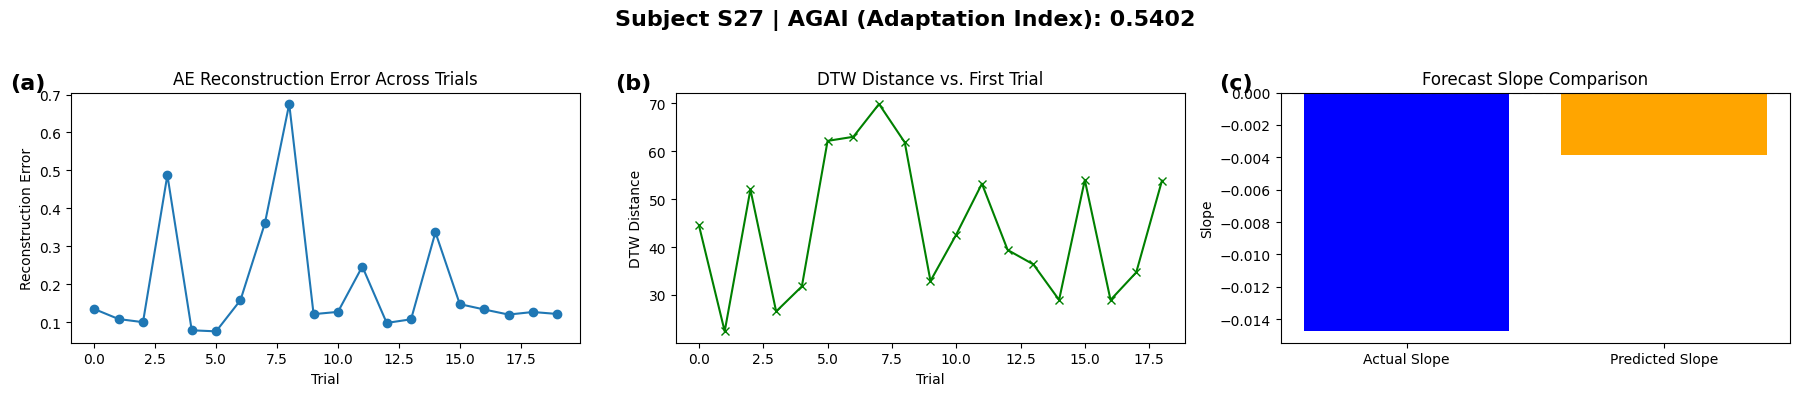

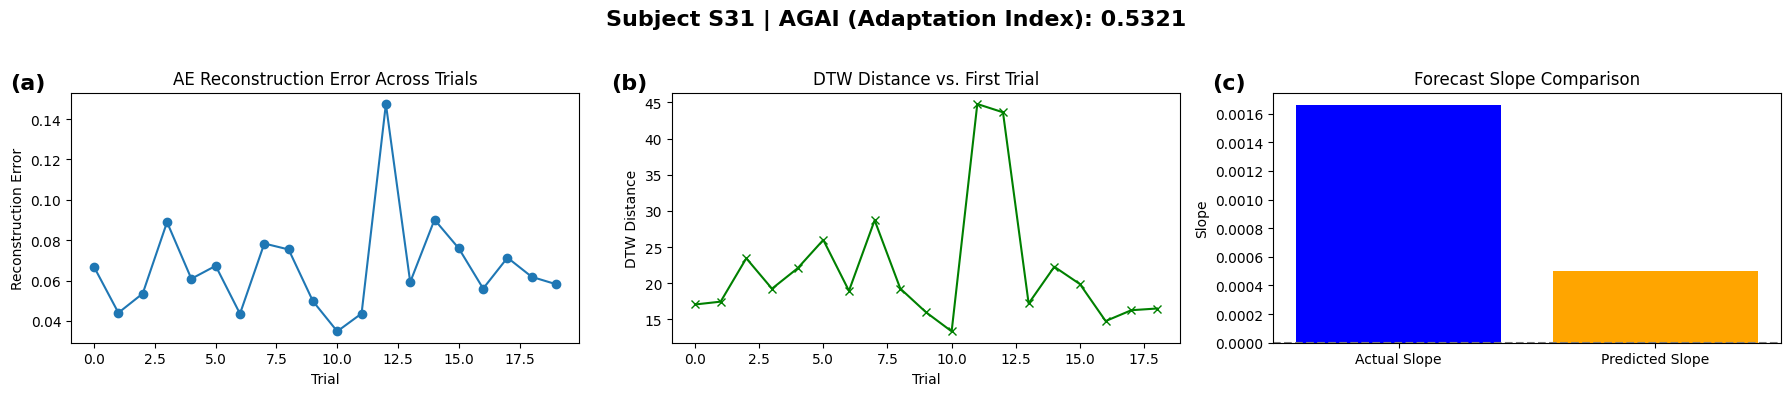

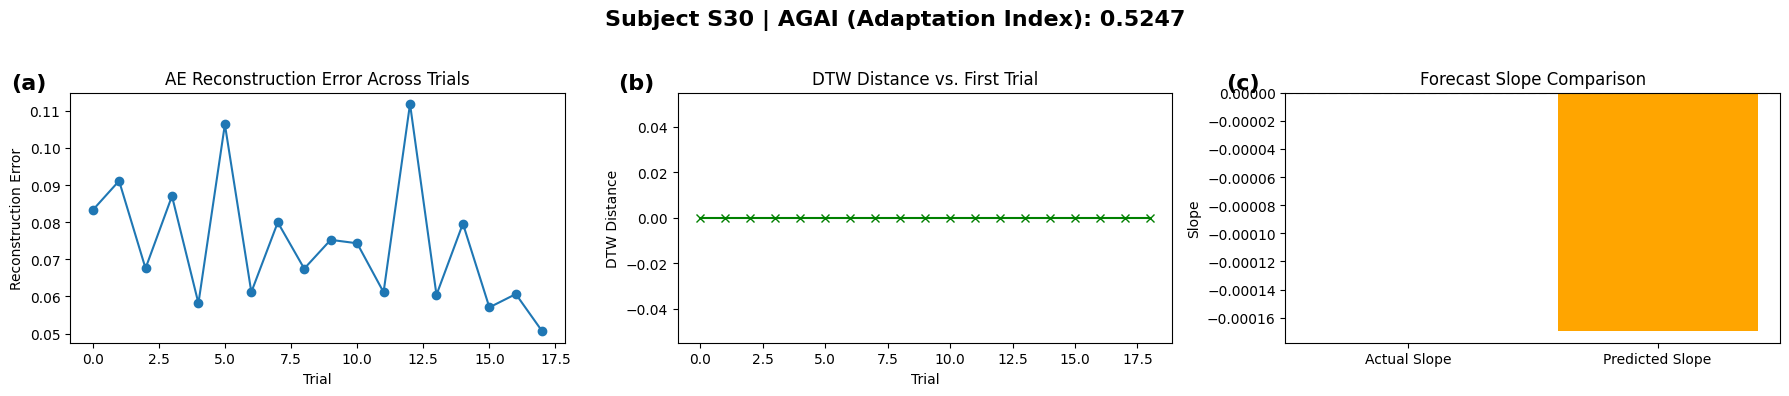

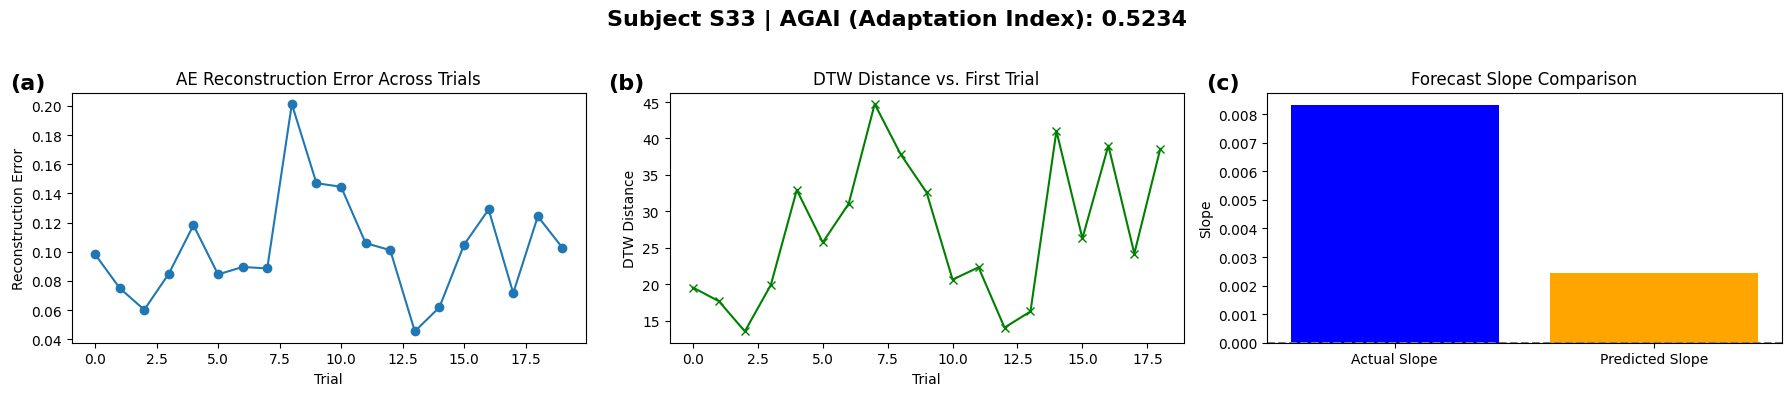

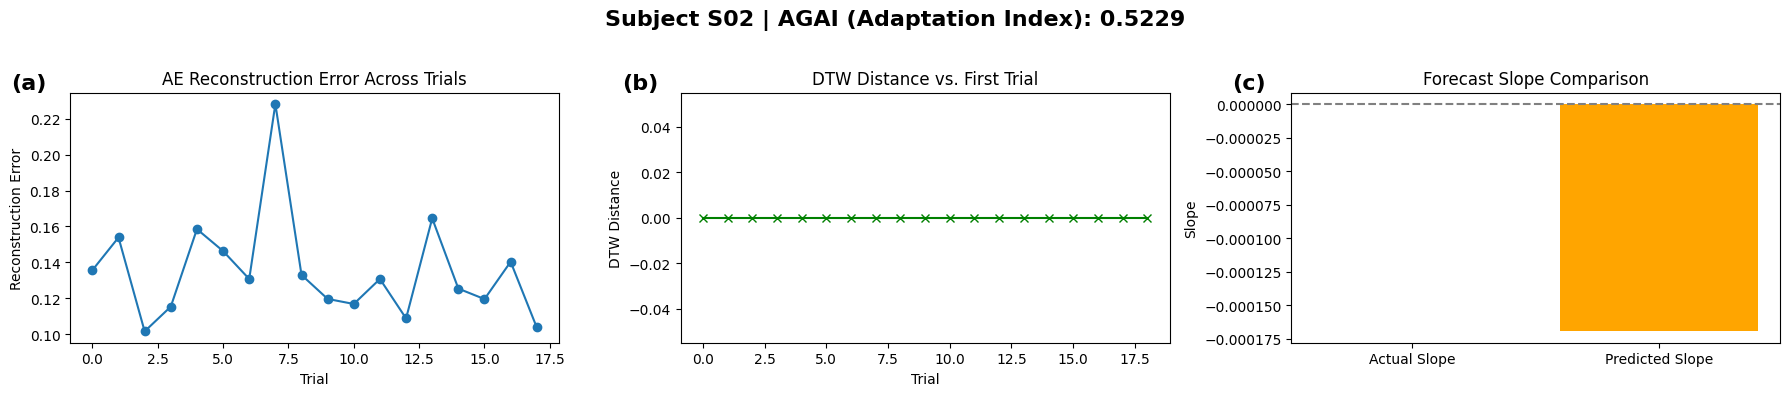

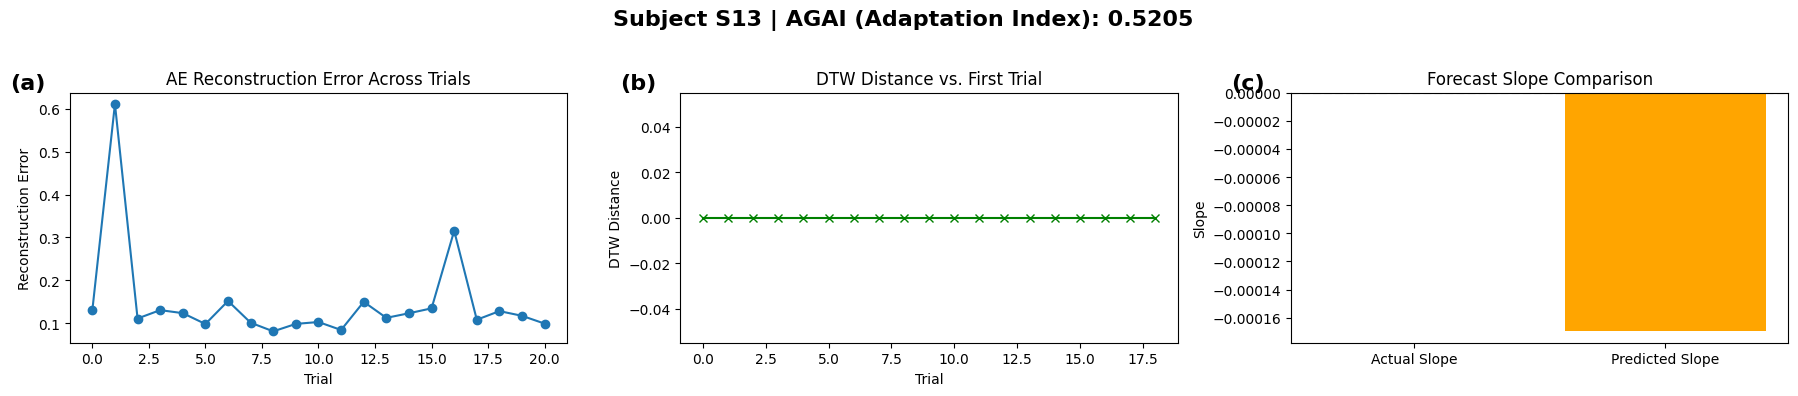

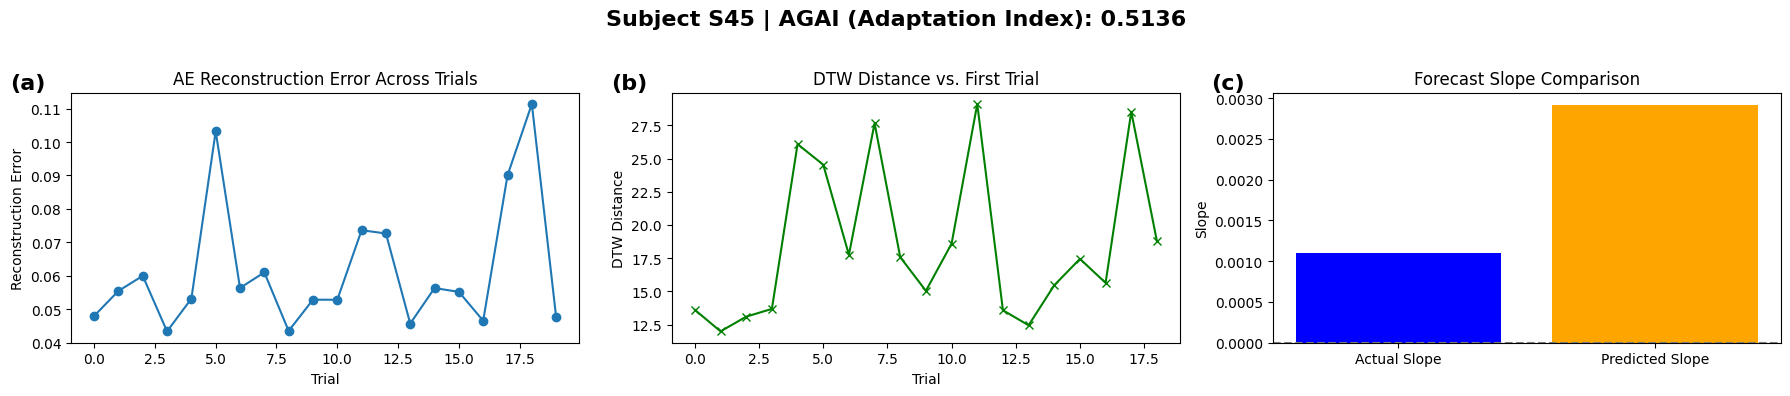

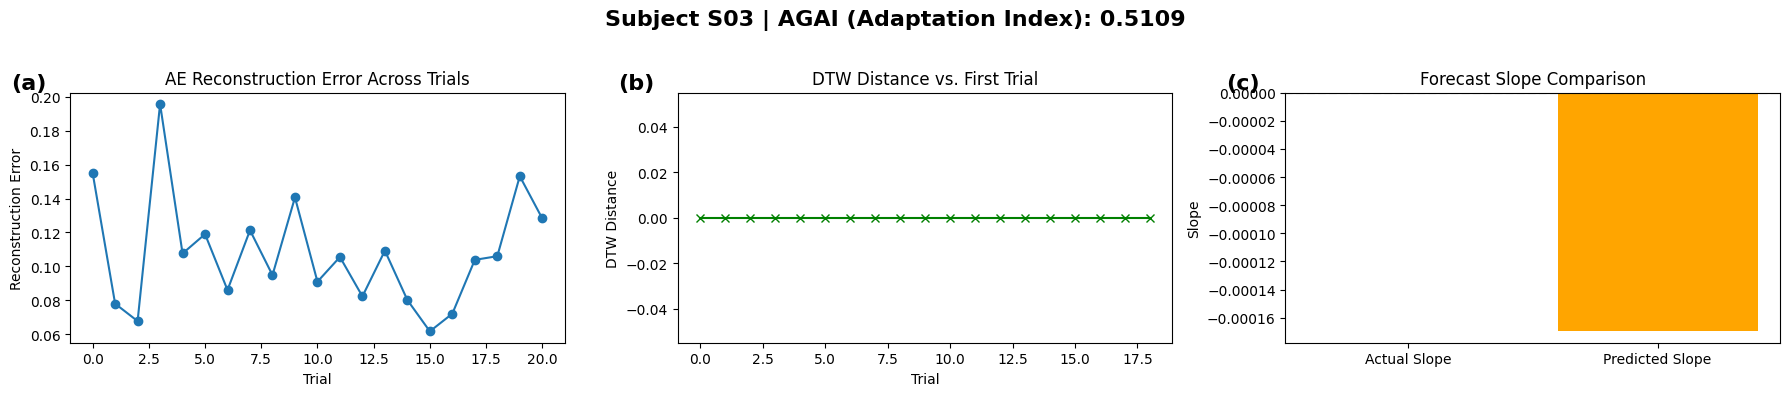

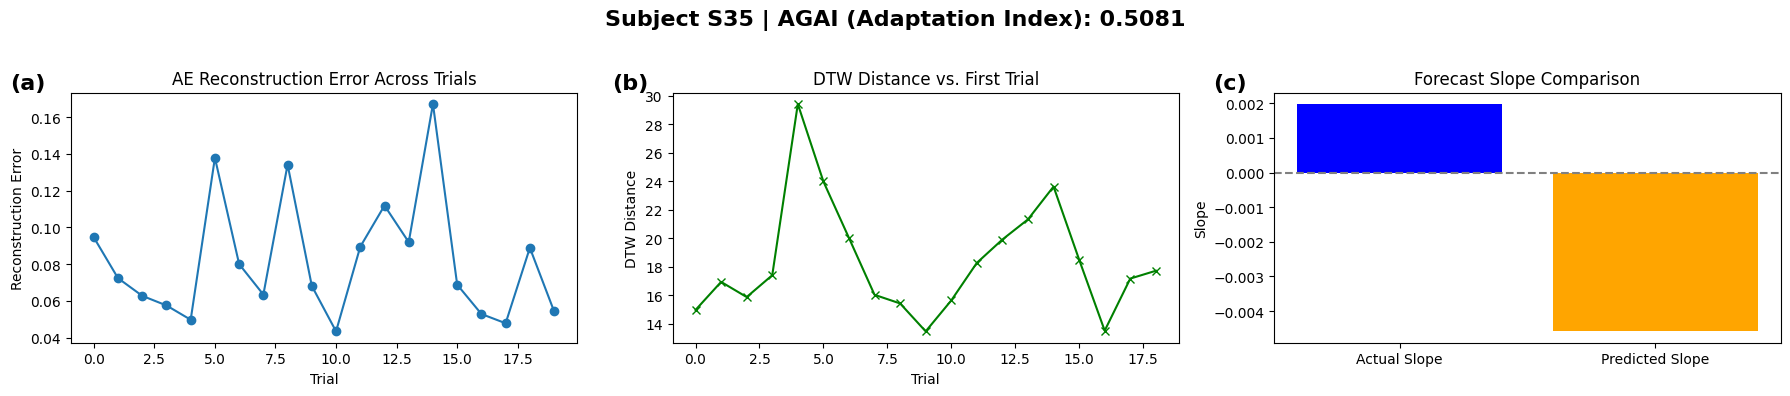

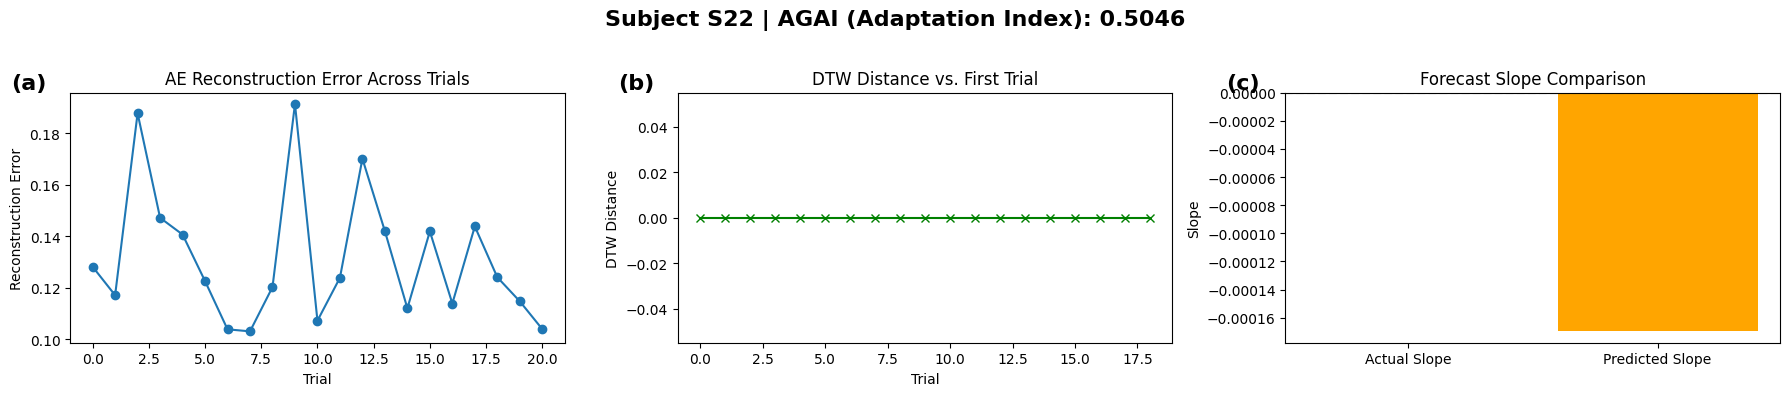

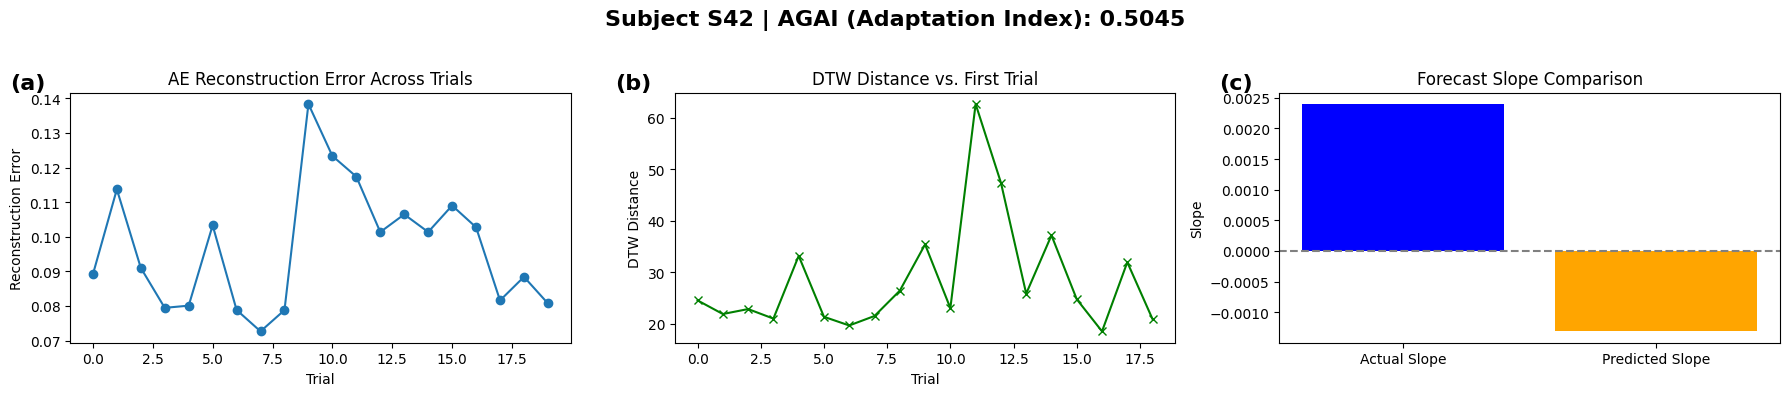

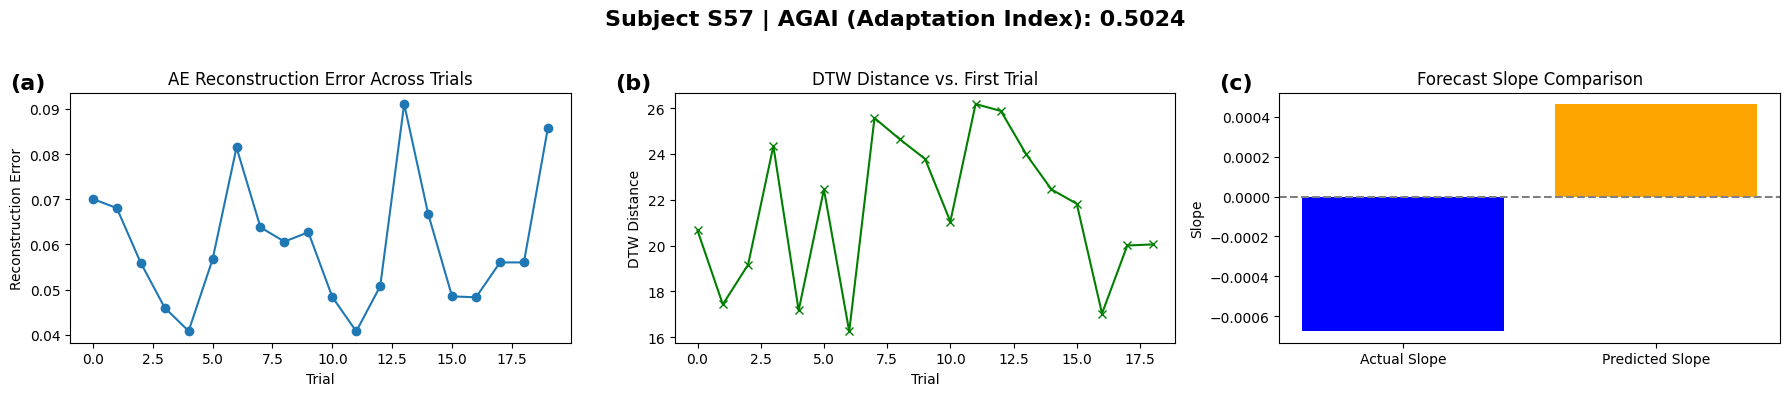

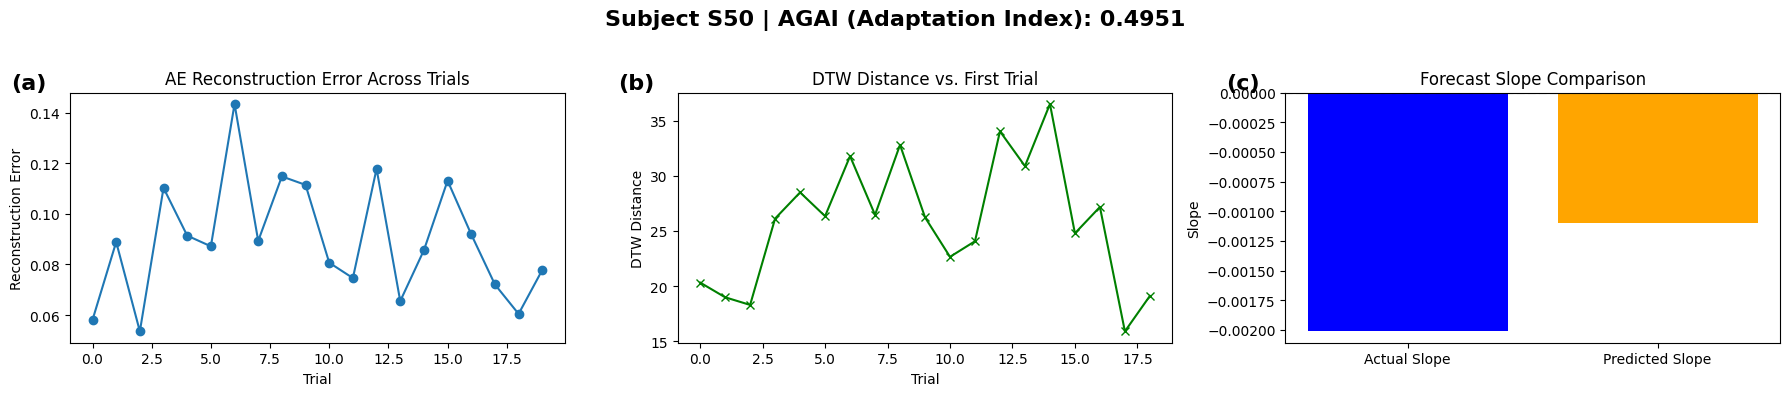

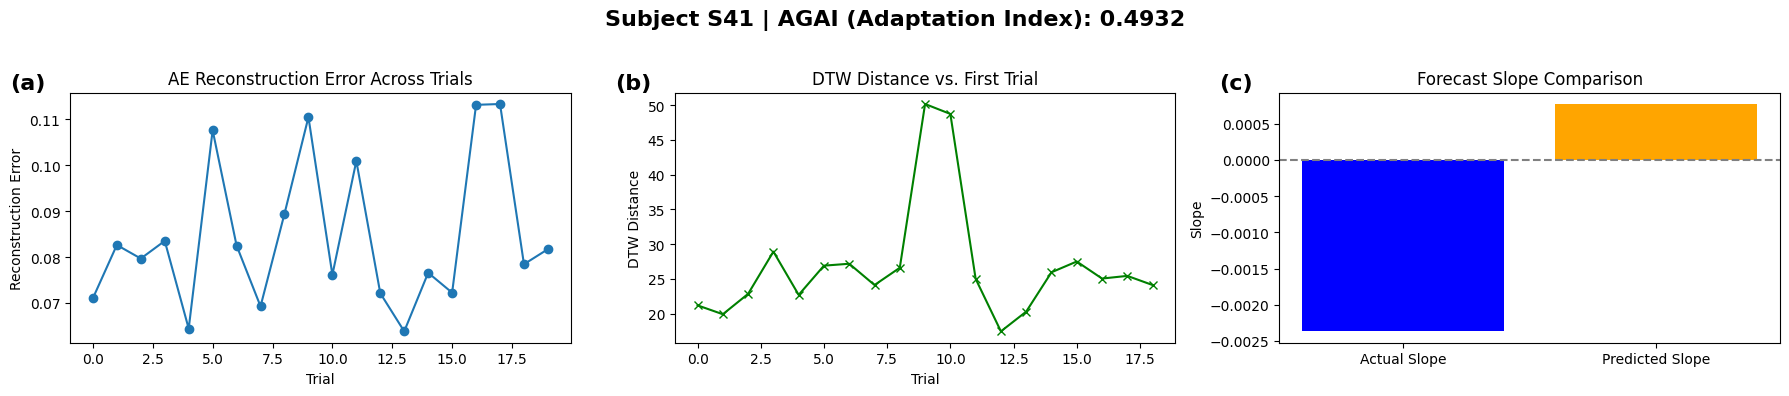

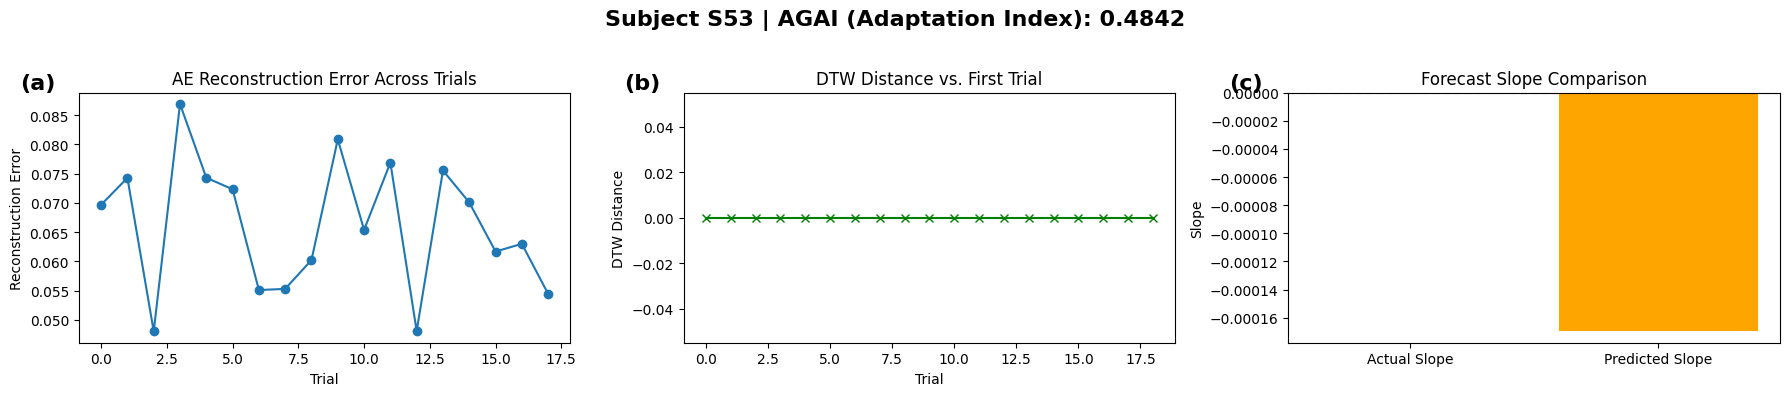

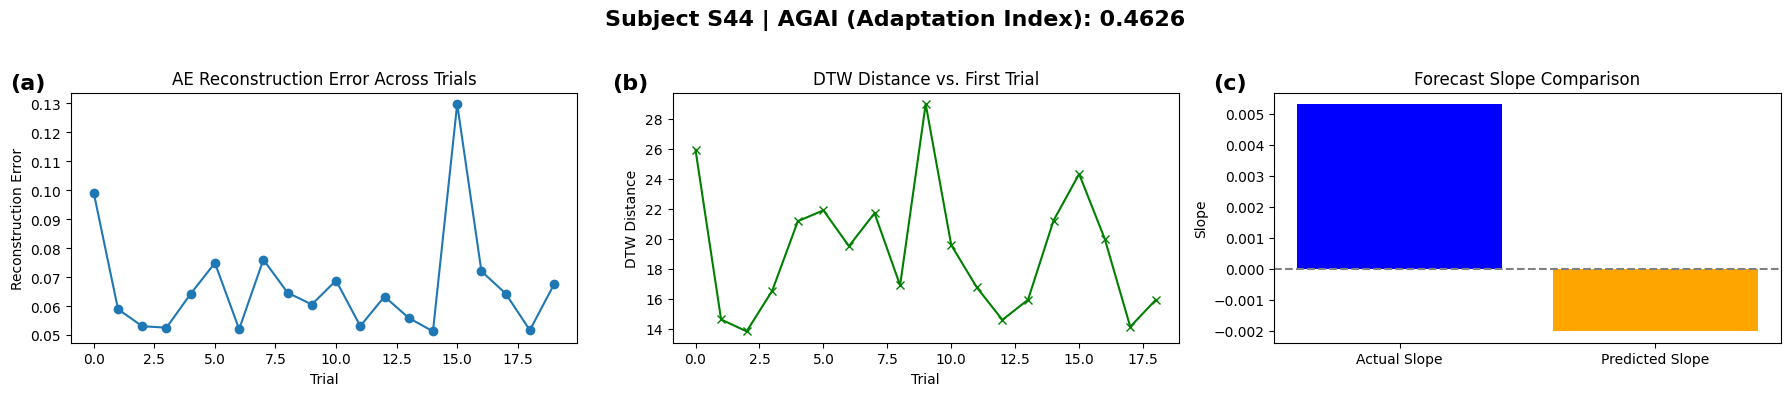

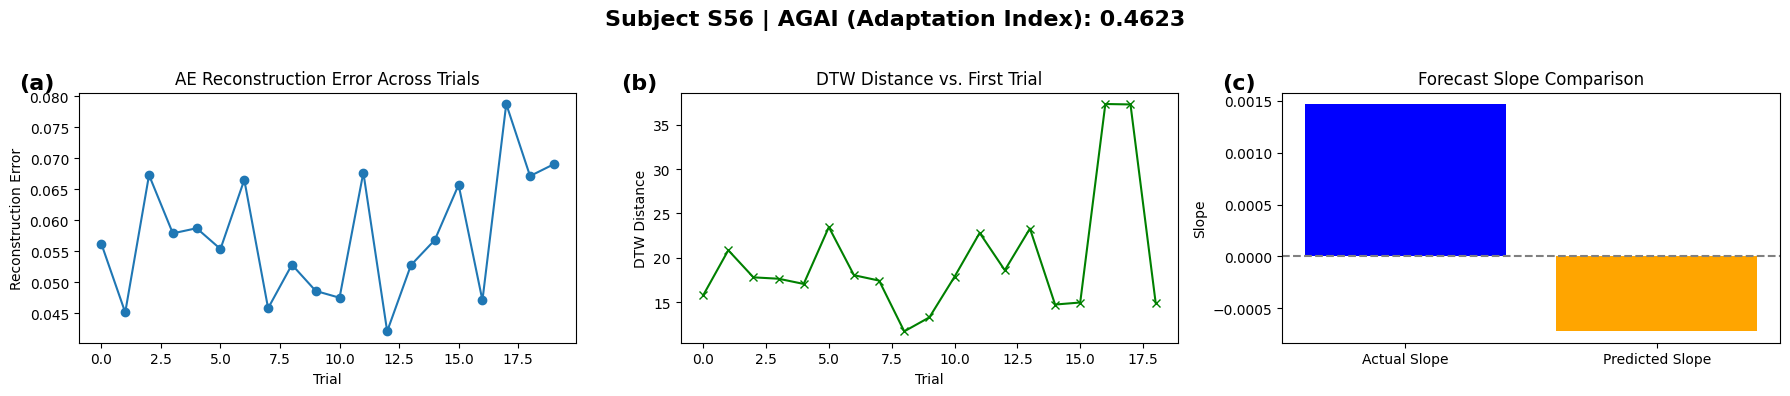

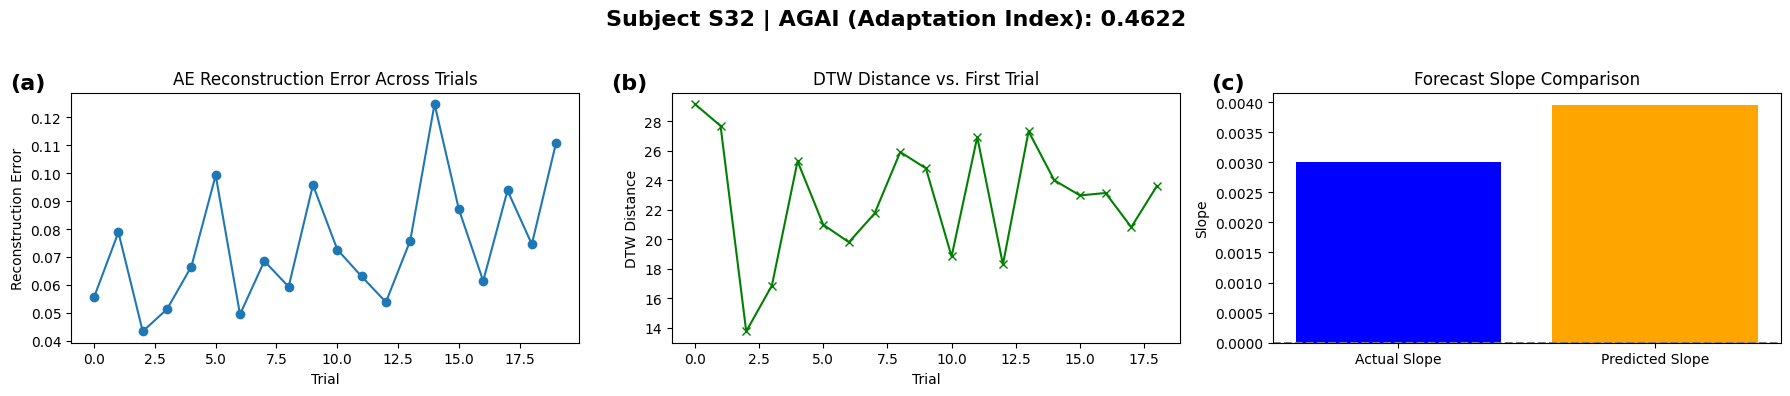

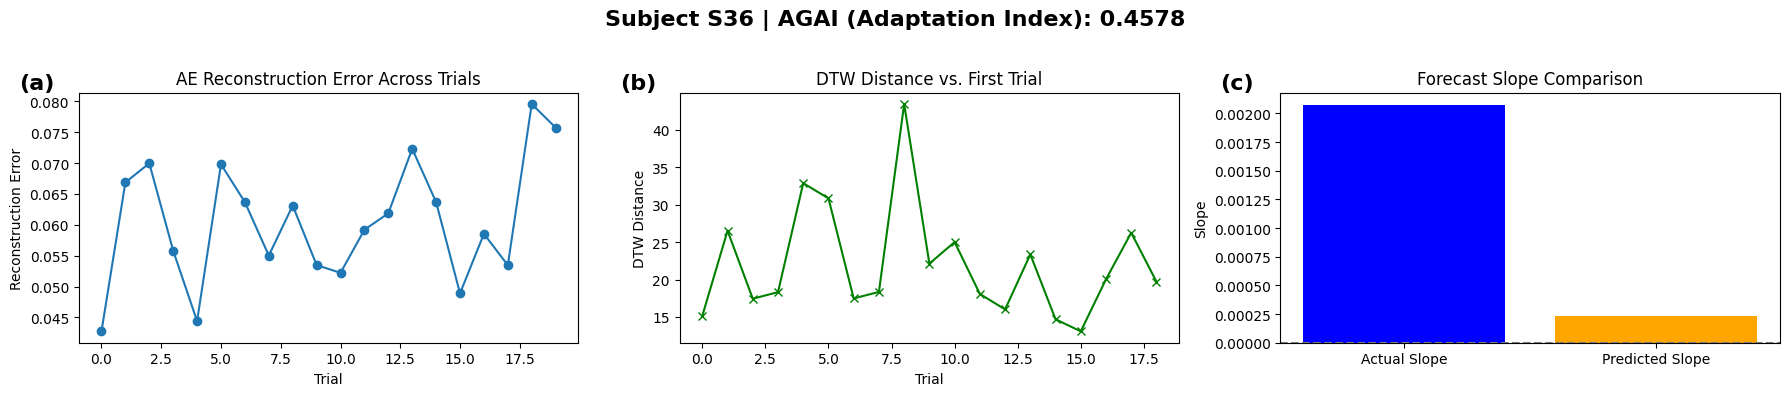

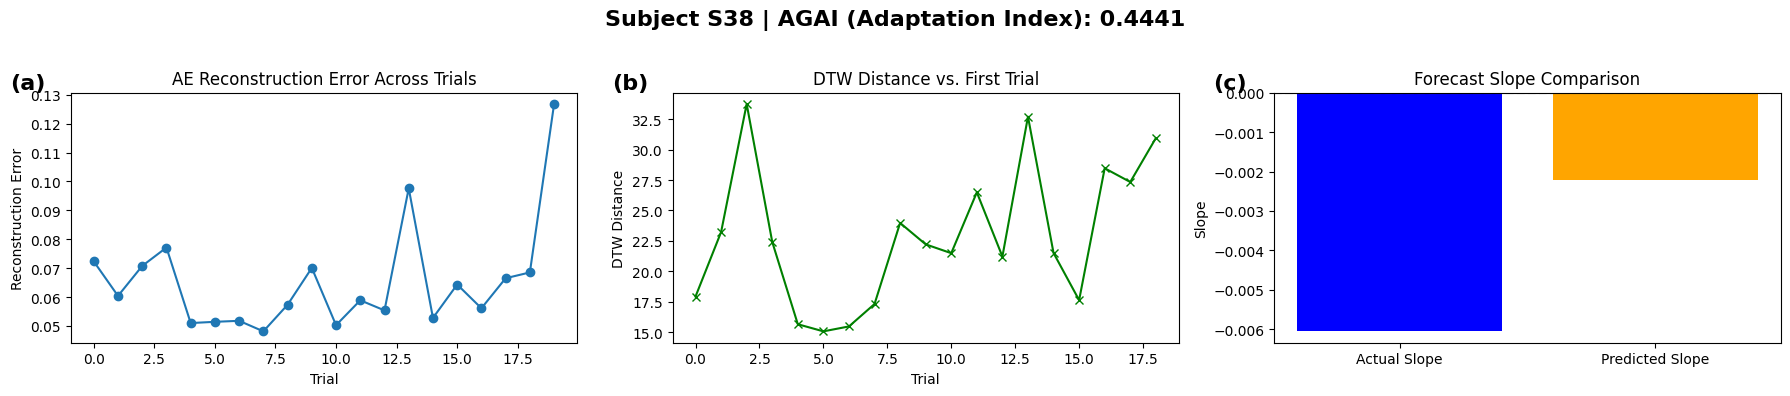

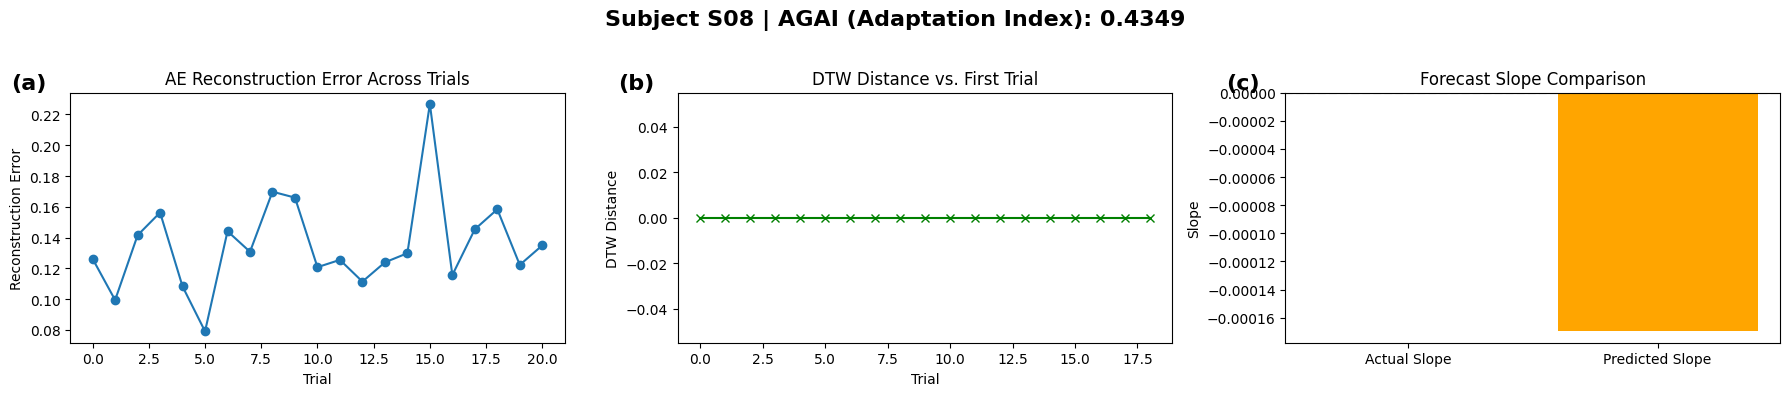

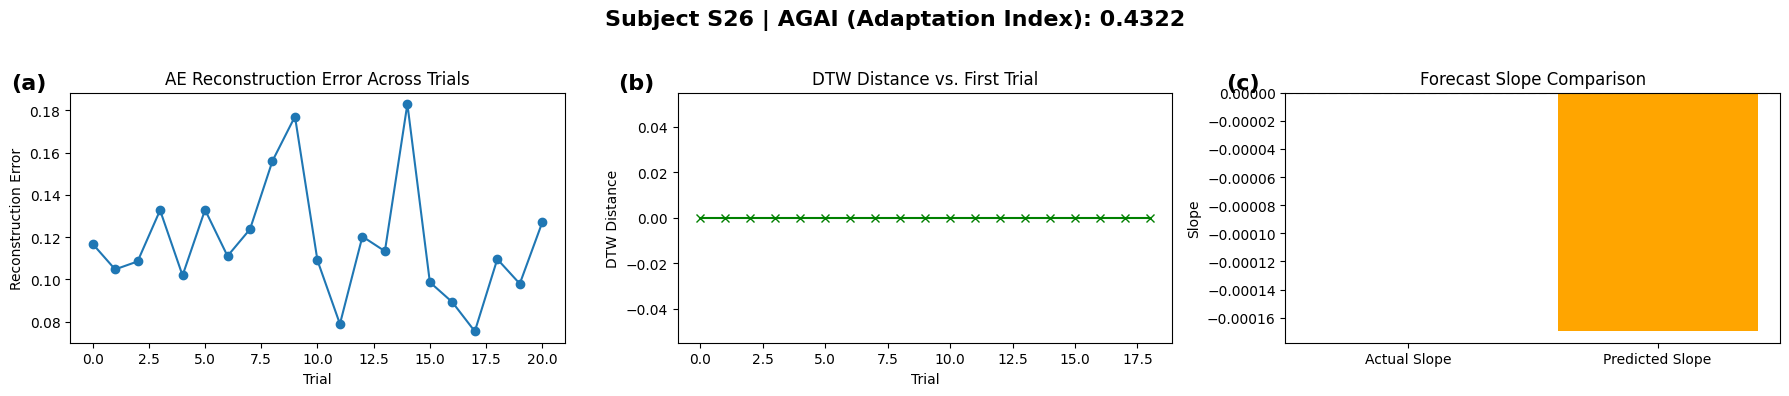

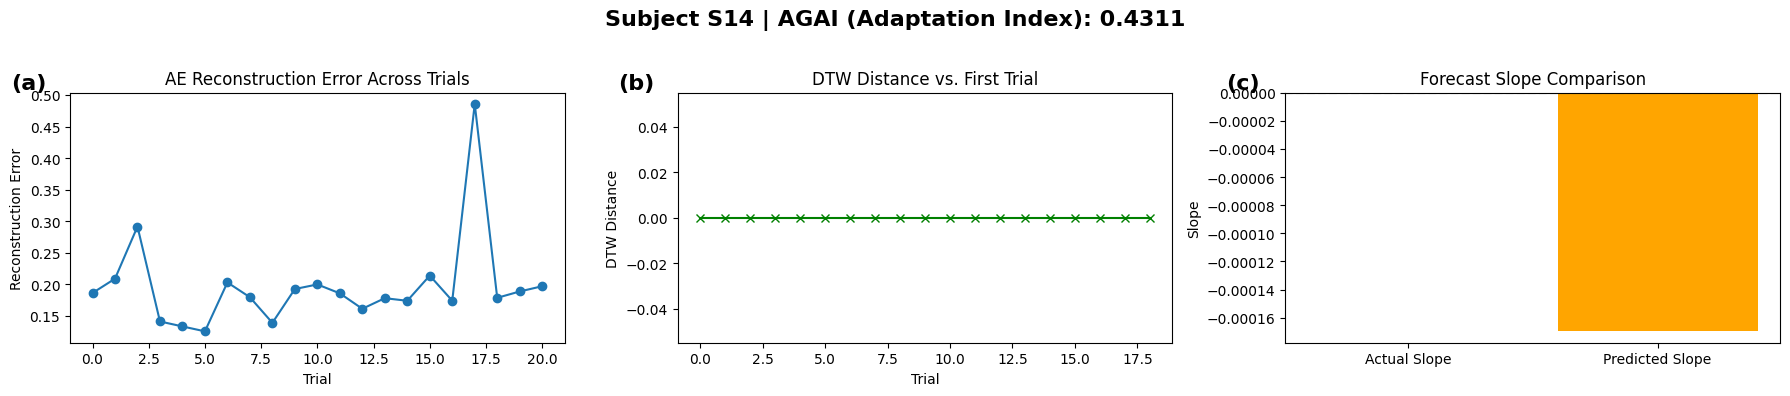

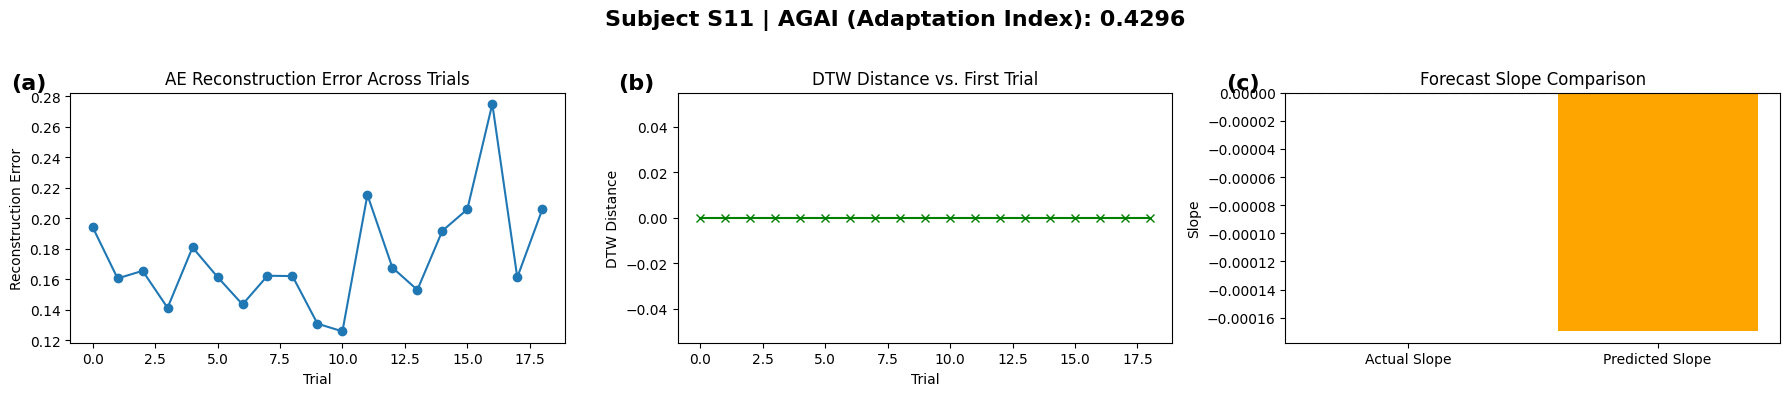

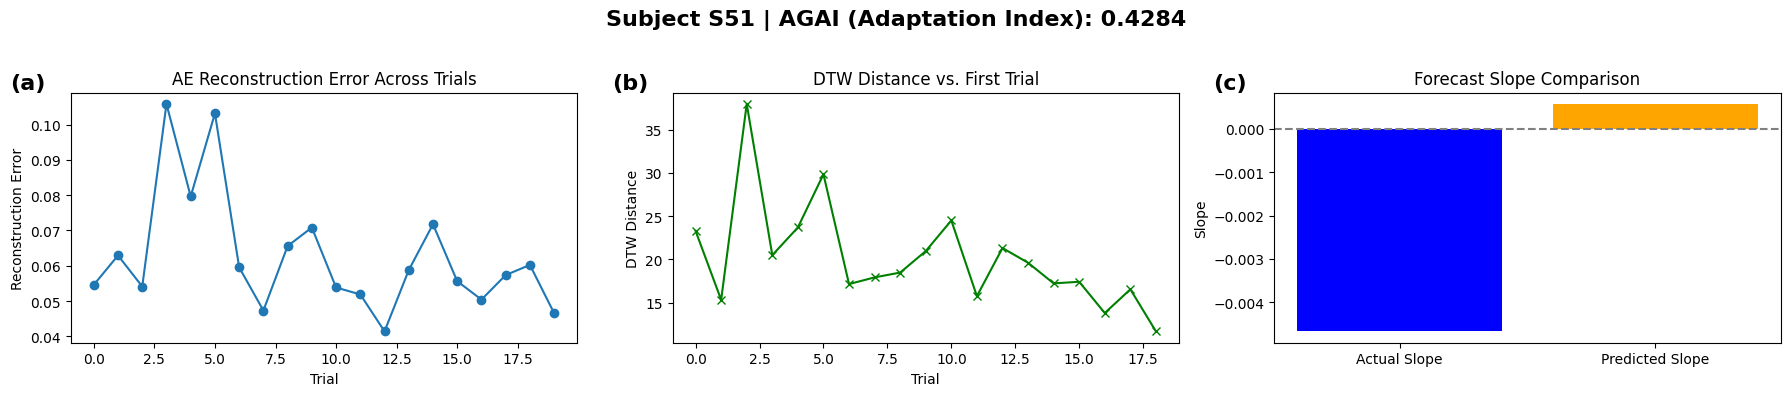

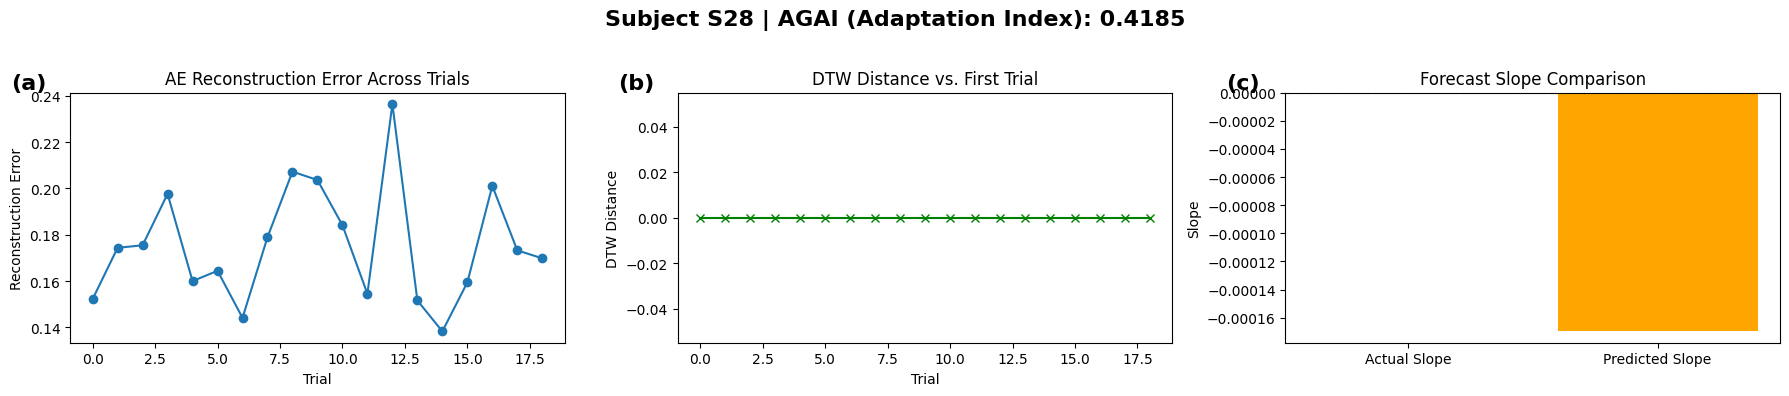

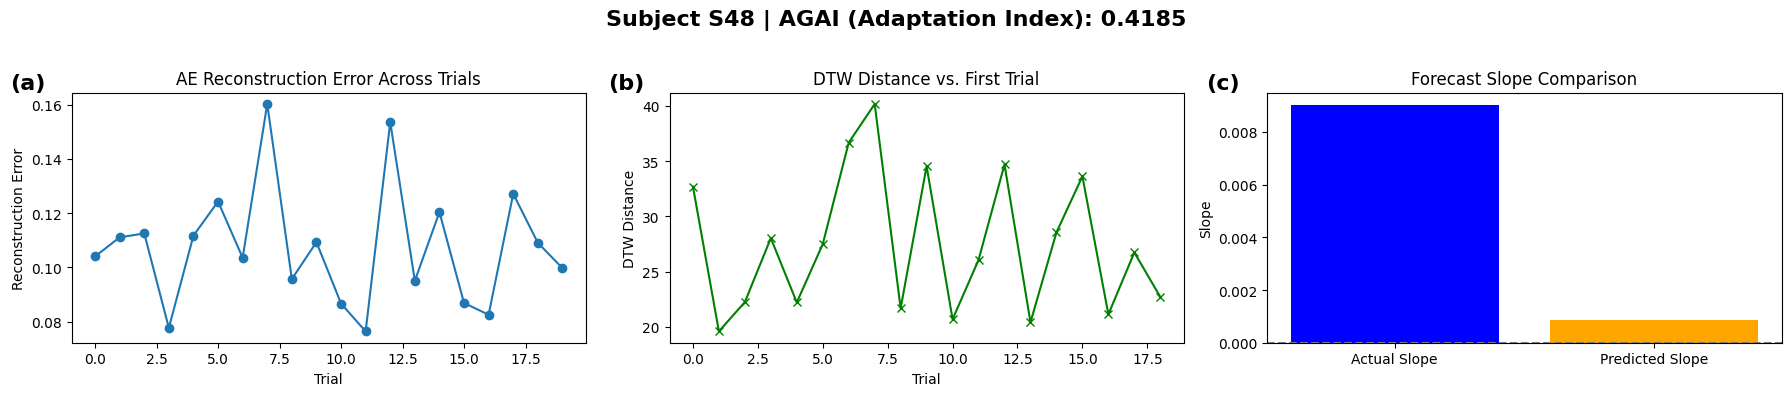

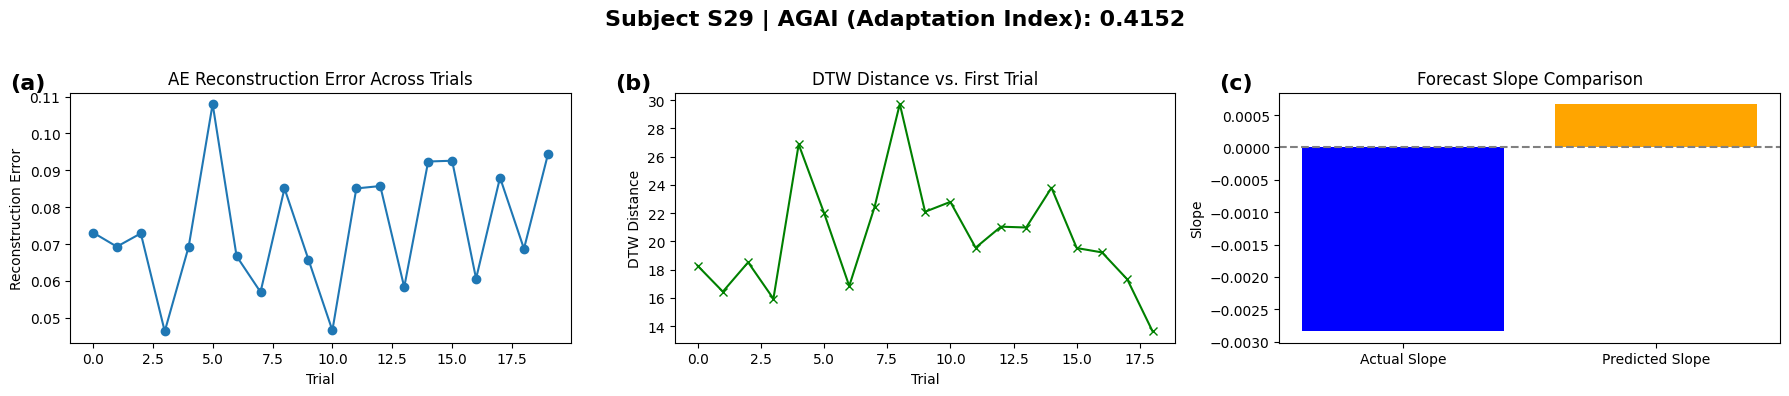

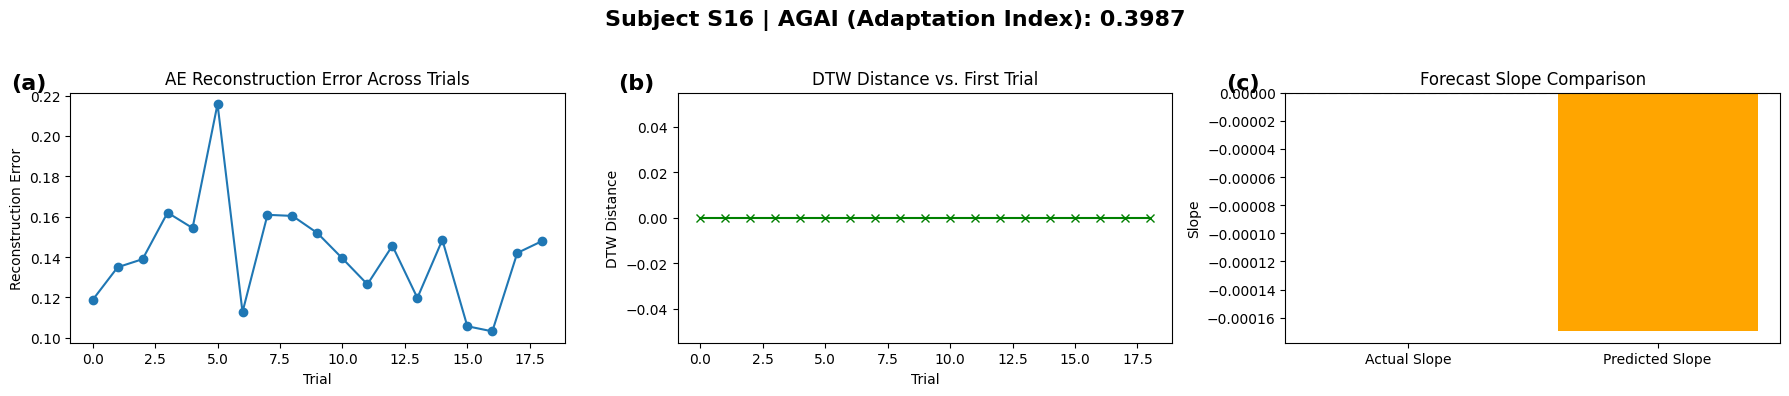

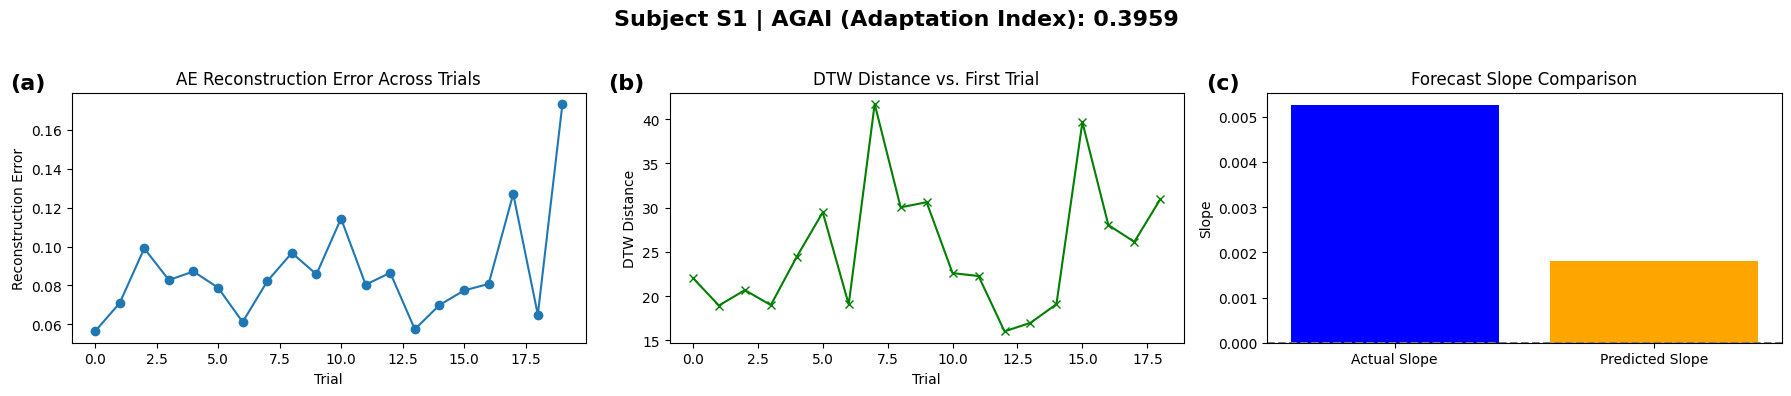

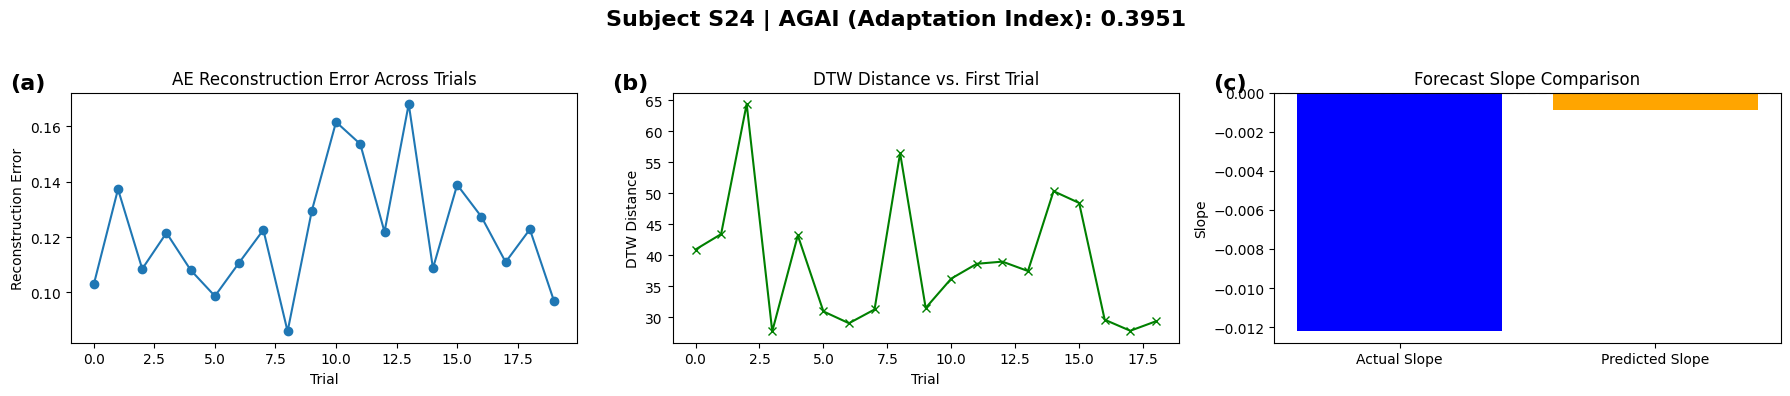

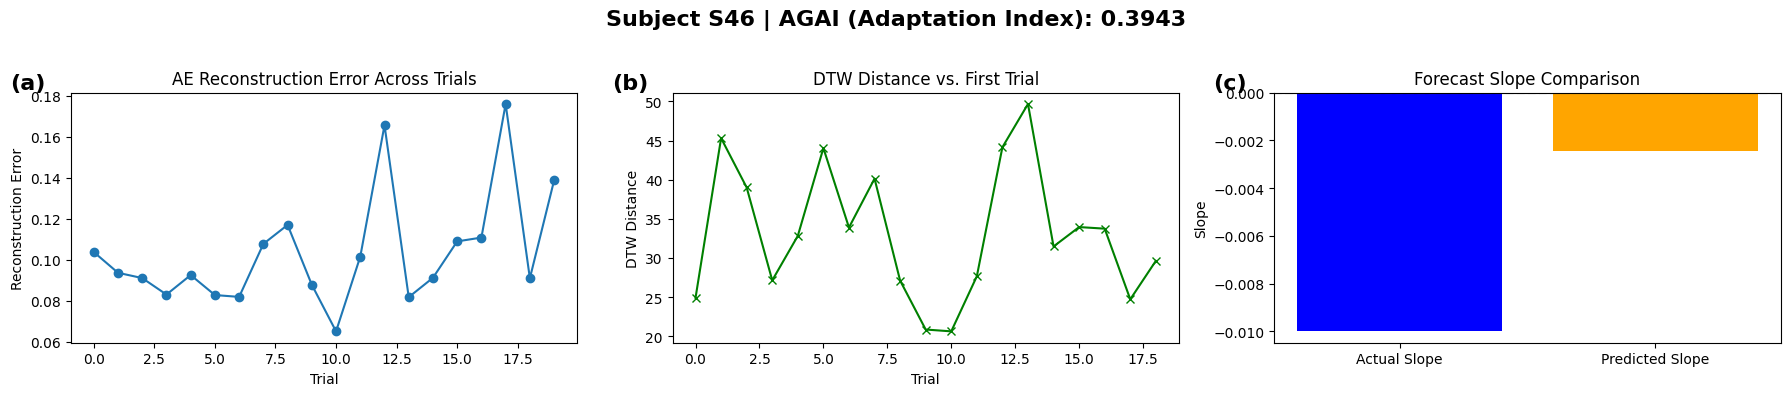

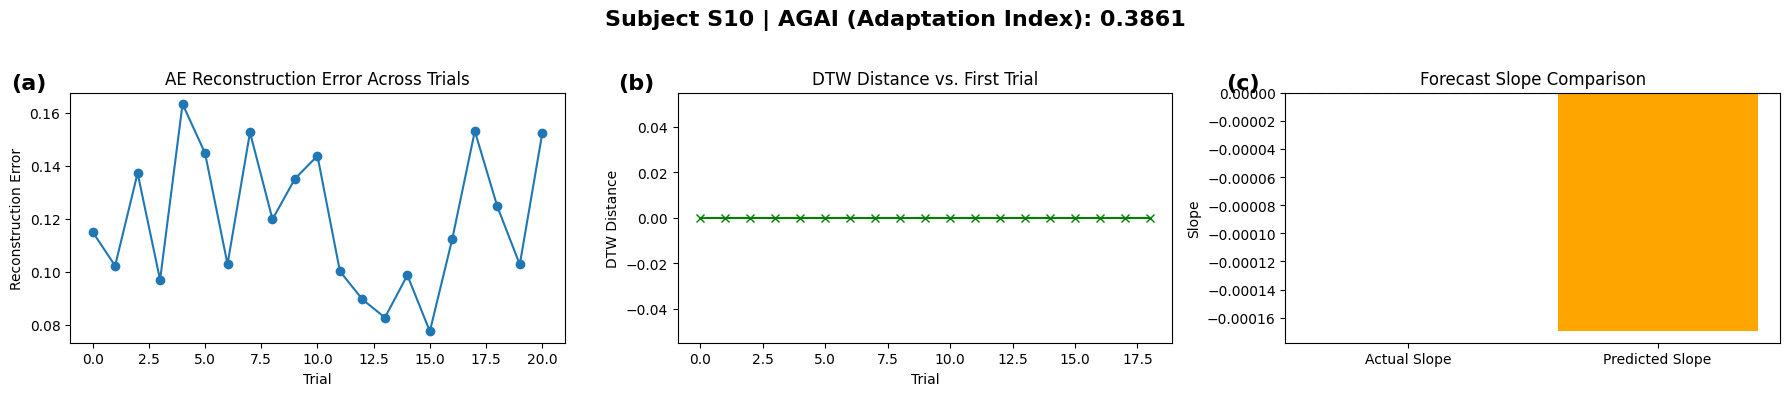

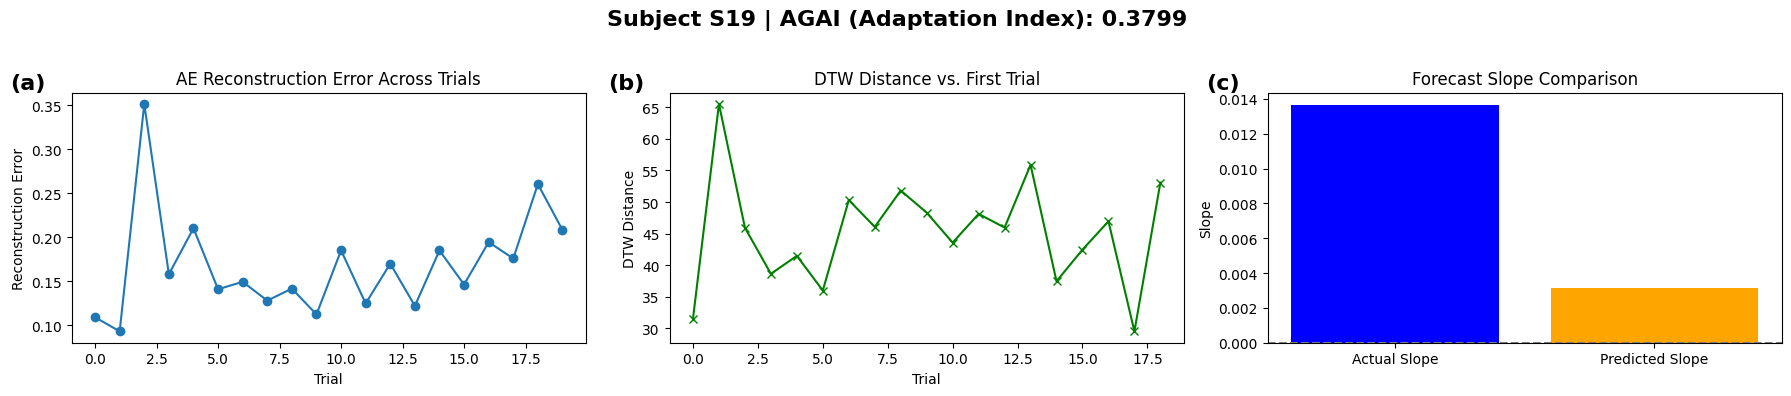

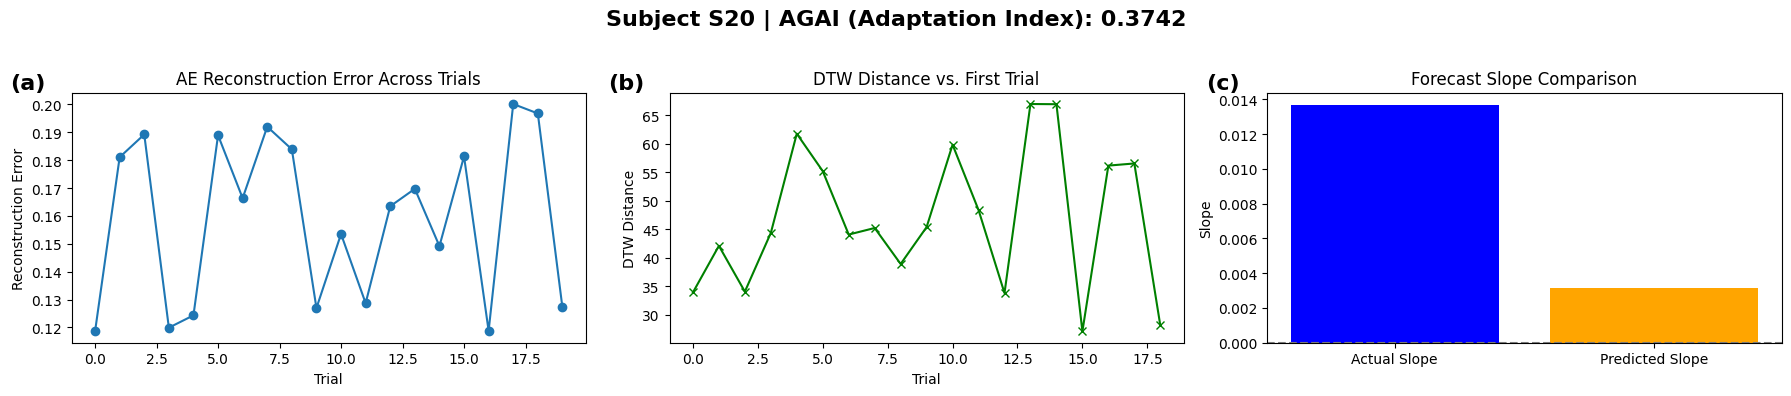

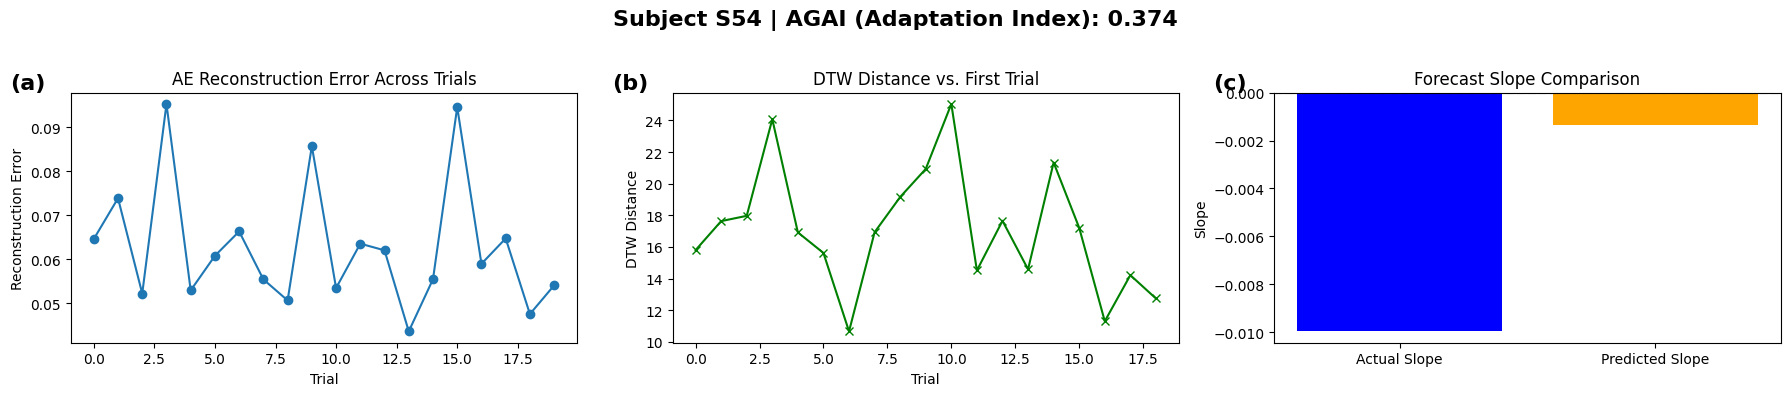

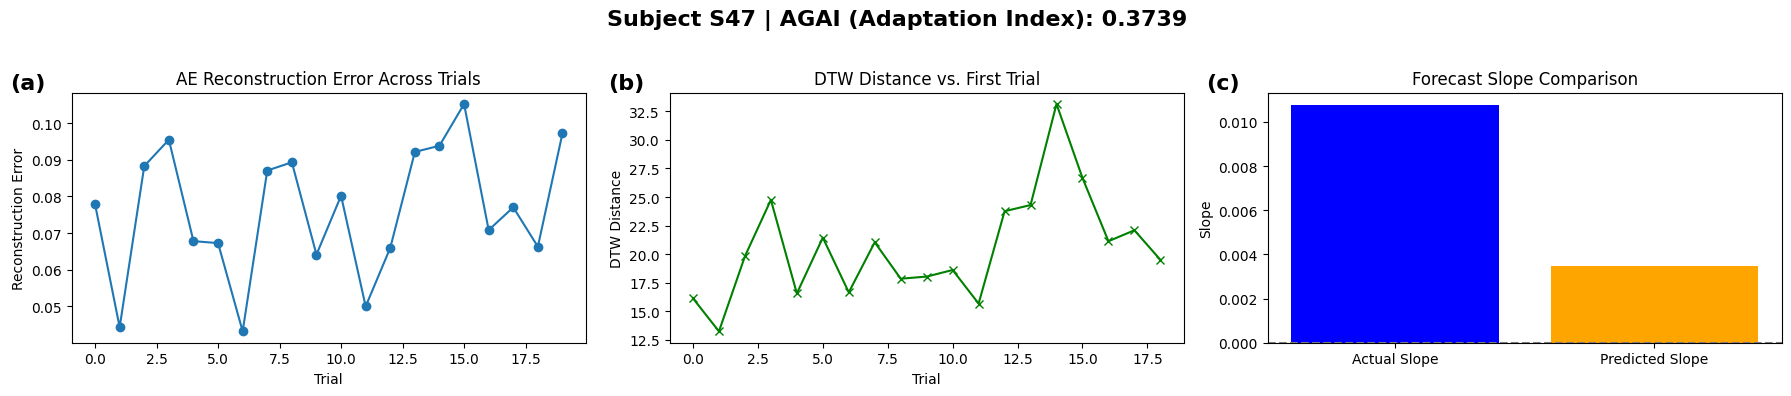

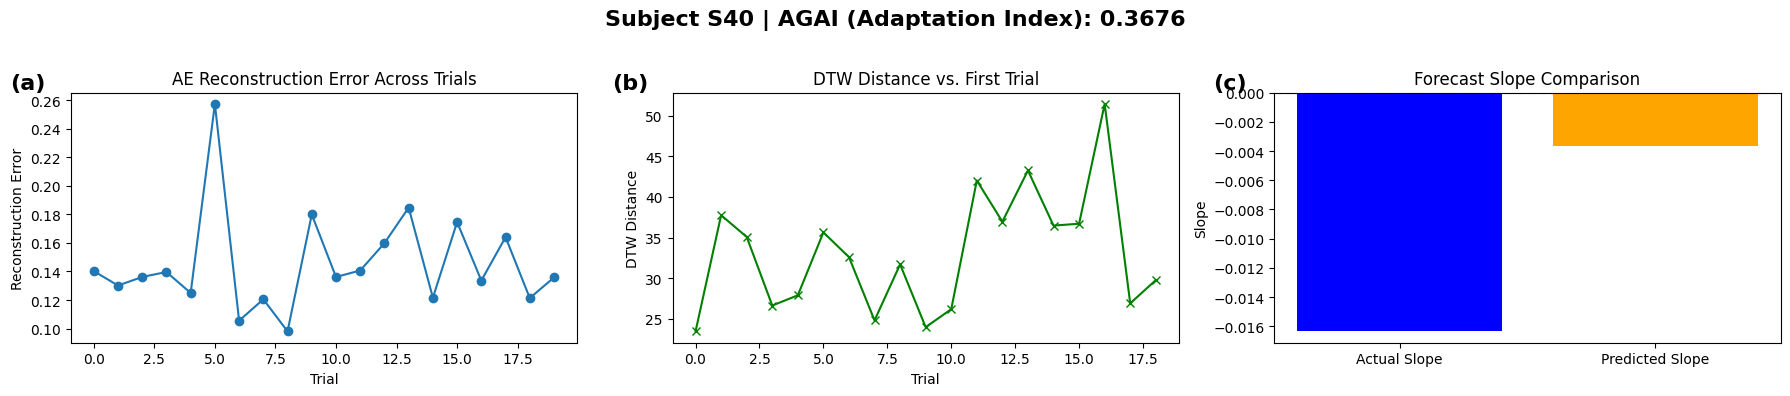

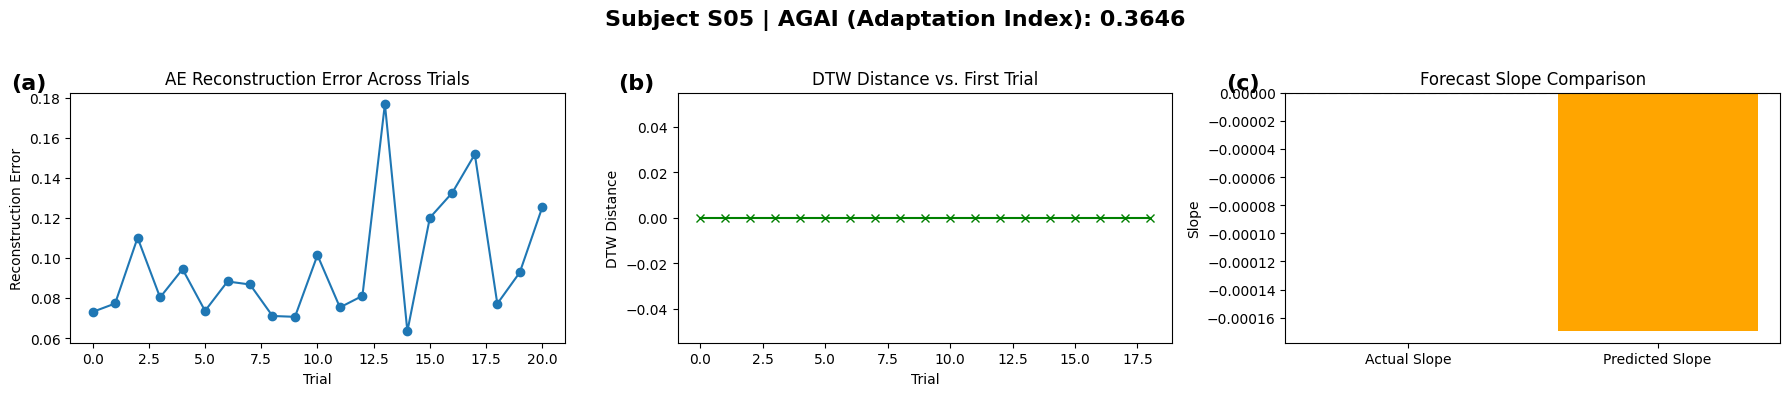

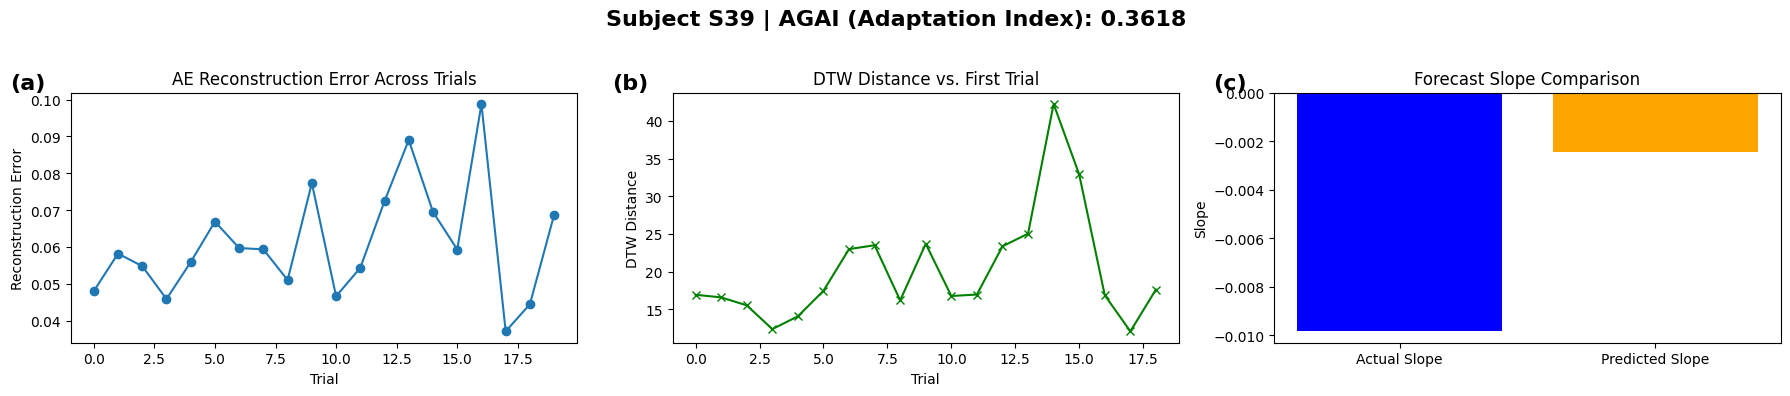

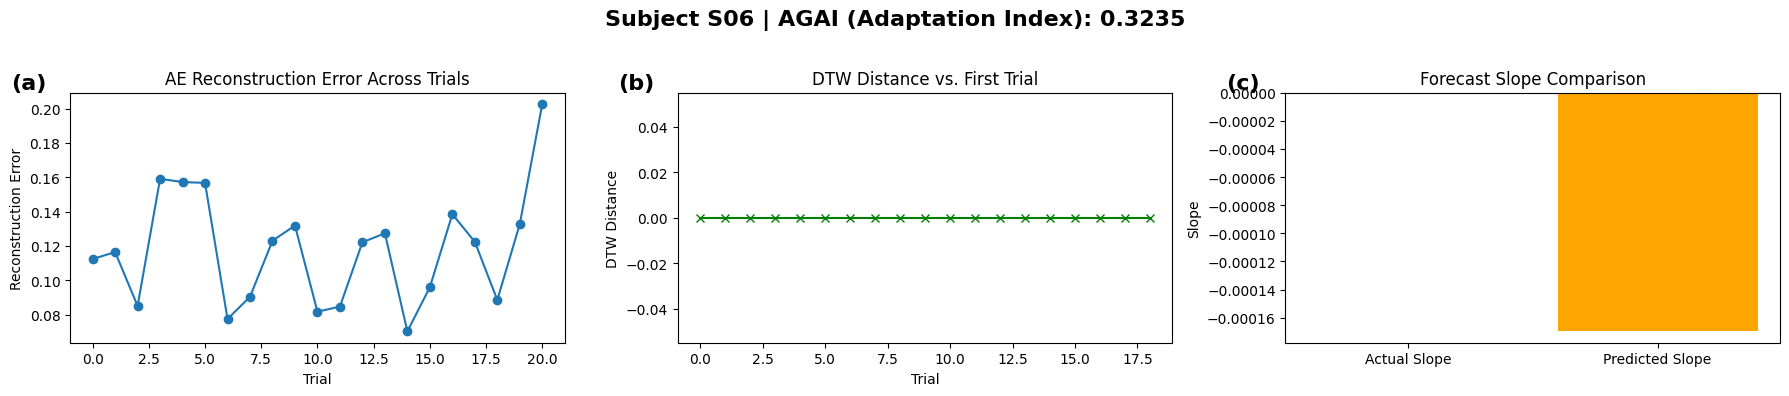

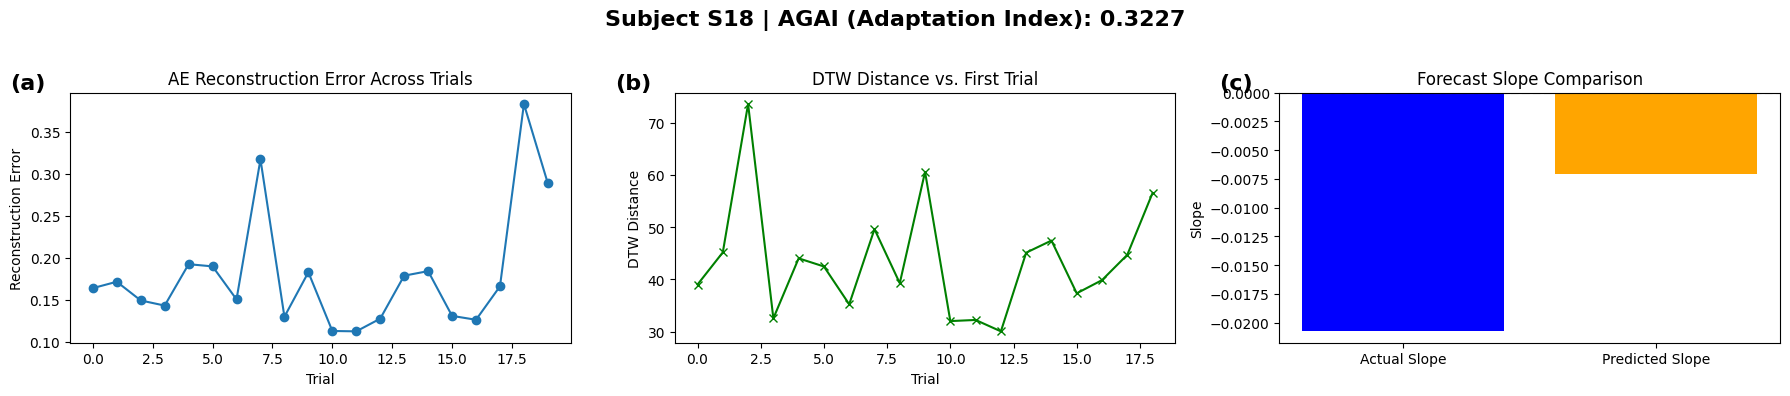

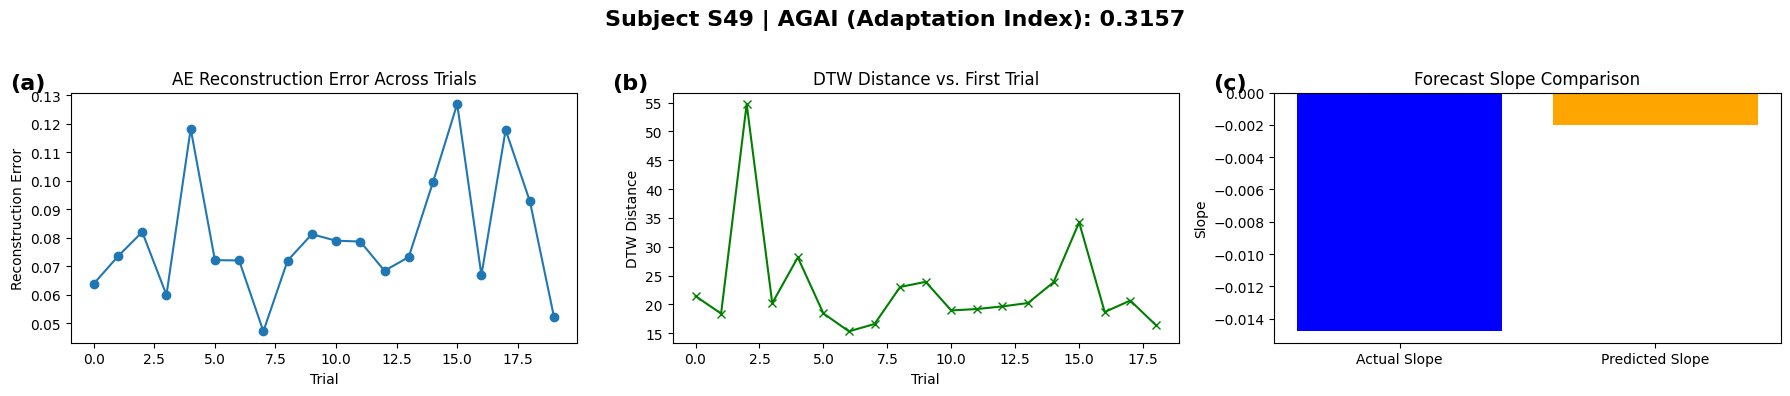

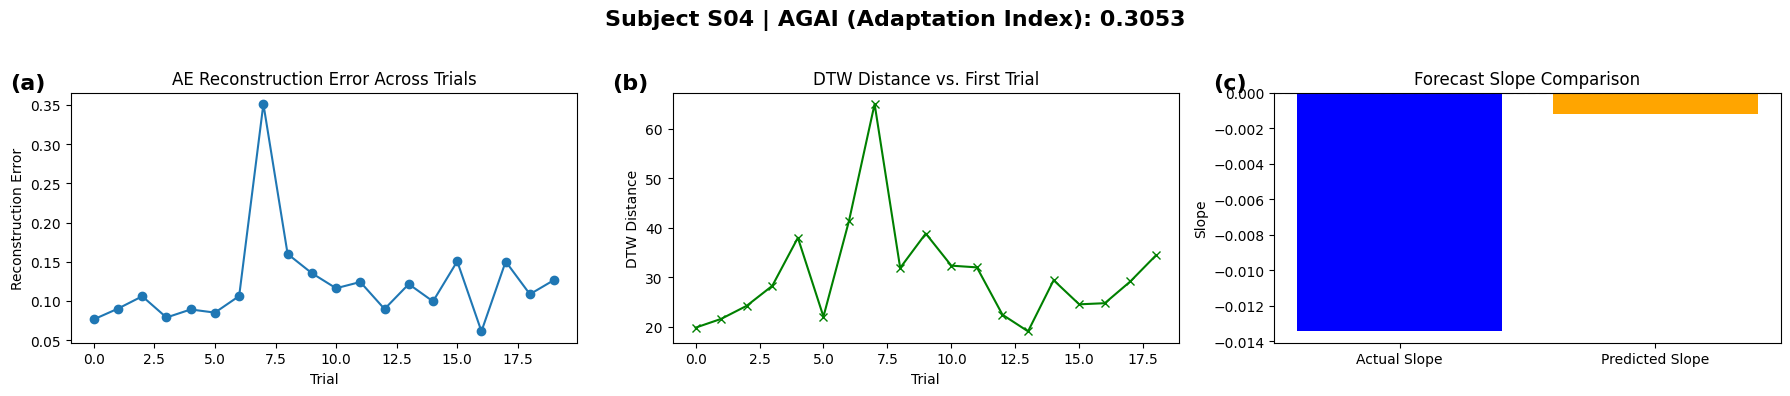

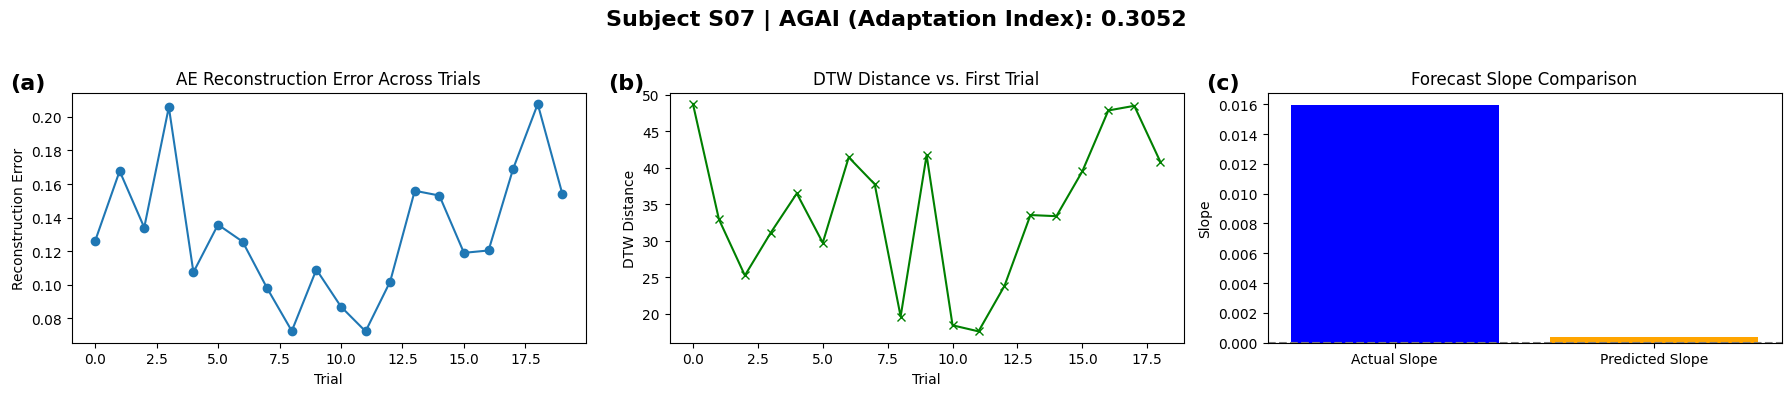

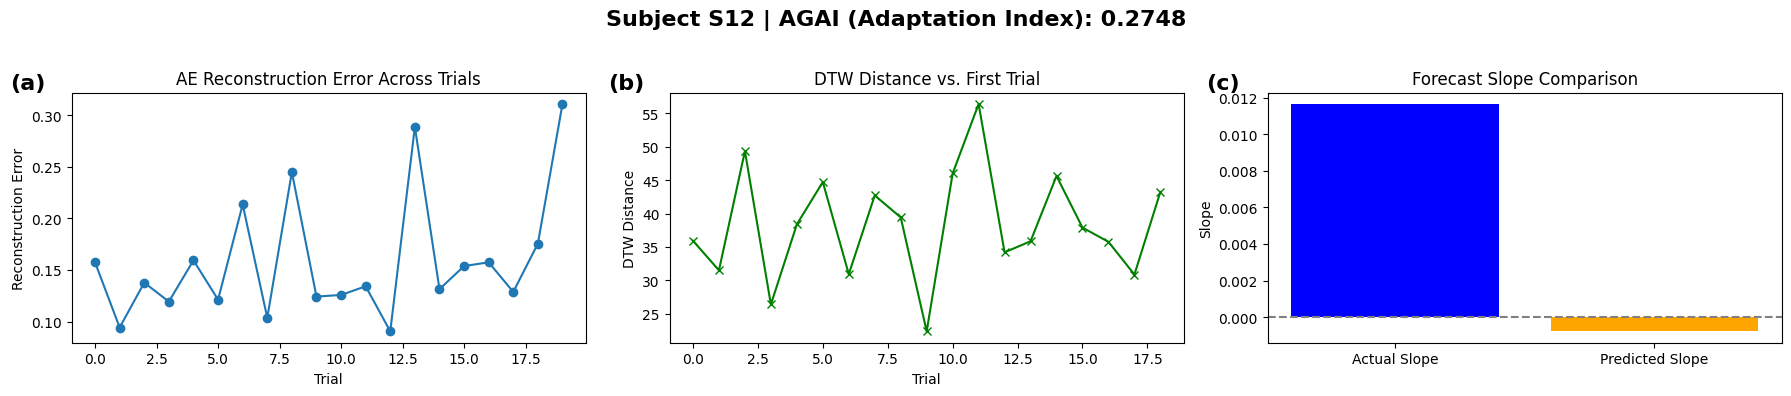

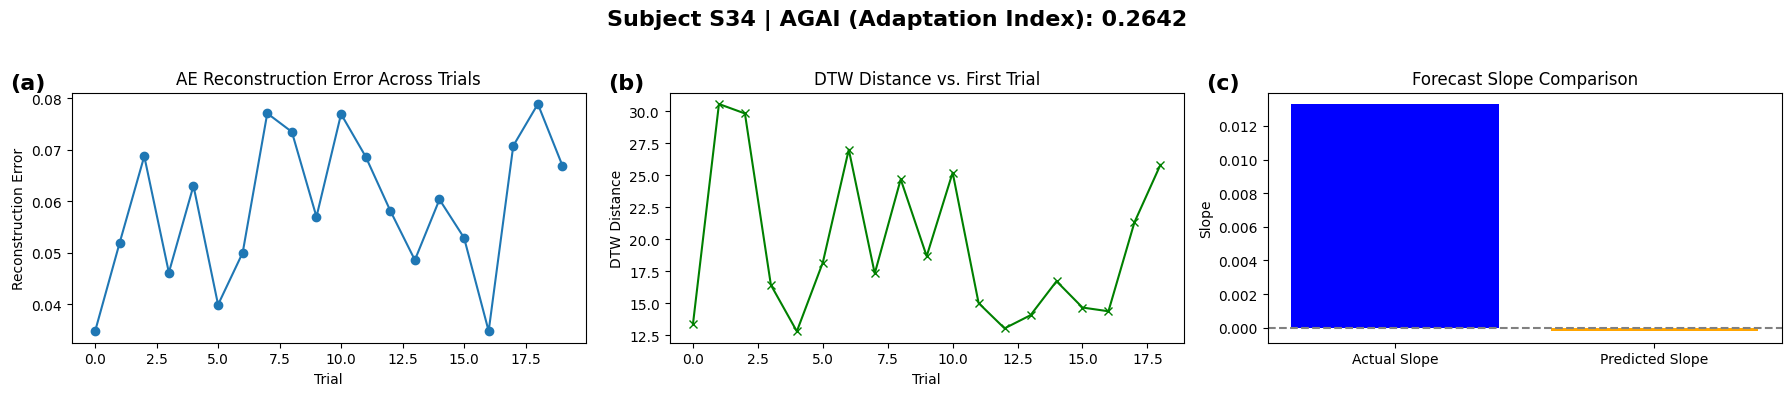

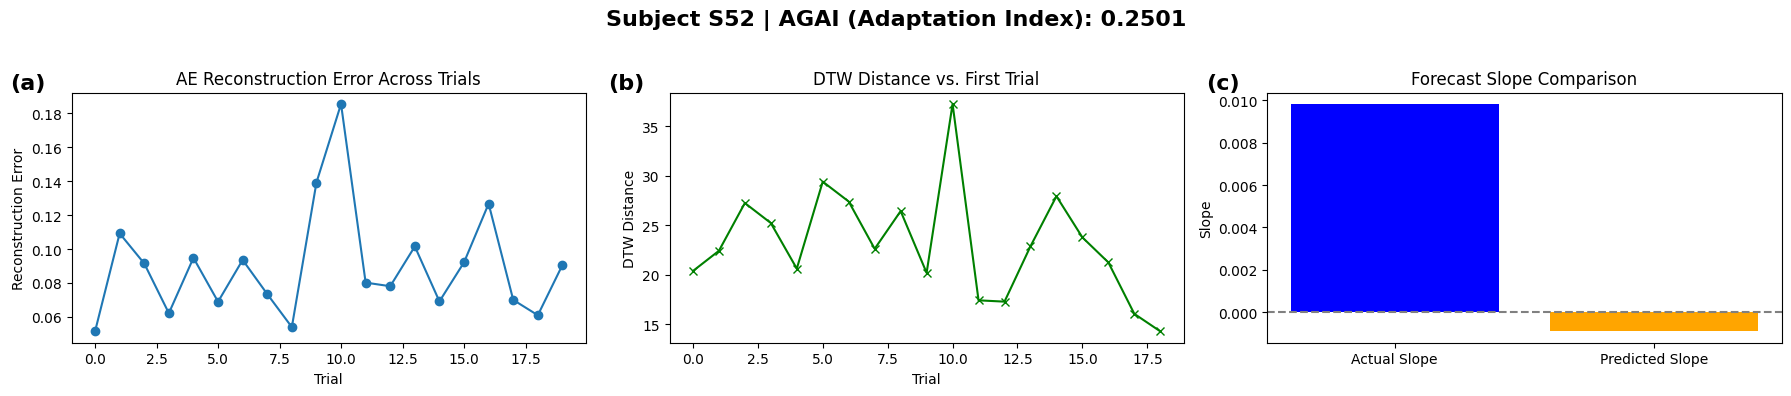

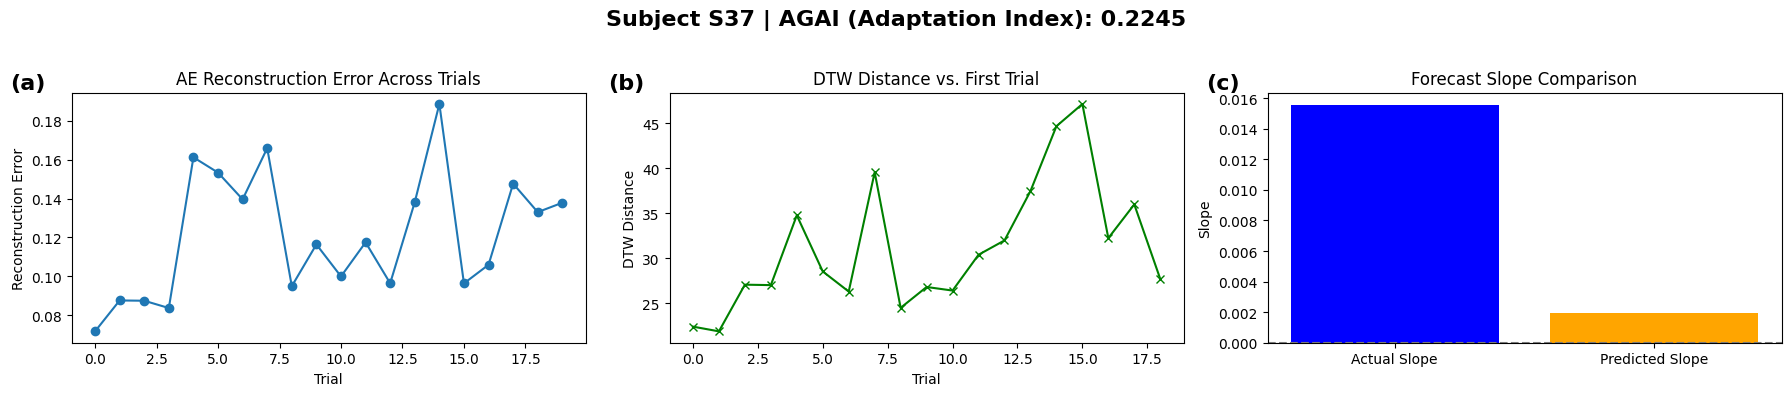

In [ ]:
for sid in sorted_agai:
    plot_subject_adaptation_panel(
        subject_id=sid,
        subject_info=subject_data[sid],
        agai_score=agai[sid],
    )

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_subject_adaptation_components(subject_id, subject_info, agai_score=None):
    ae = subject_info["autoencoder"]
    dtw = subject_info["dtw"]
    forecast = subject_info["forecasting"]

    rec = ae["reconstruction_error"]
    dtw_curve = dtw["dtw_curve"]
    real_slope = forecast["real_slope"]
    pred_slope = forecast["pred_slope"]

    title_base = f"Subject {subject_id} | AGAI: {round(agai_score, 4) if agai_score is not None else 'N/A'}"

    # (a) AE Reconstruction Error
    plt.figure(figsize=(6, 4))
    plt.plot(rec, marker='o')
    plt.title(f"{title_base}\n AE Reconstruction Error Across Trials")
    plt.xlabel("Trial")
    plt.ylabel("Reconstruction Error")
    plt.tight_layout()
    plt.savefig(f"subject_{subject_id}_a_ae.png")
    plt.show()

    # (b) DTW Distance Curve
    plt.figure(figsize=(6, 4))
    plt.plot(dtw_curve, marker='x', color='green')
    plt.title(f"{title_base}\n DTW Distance vs. First Trial")
    plt.xlabel("Trial")
    plt.ylabel("DTW Distance")
    plt.tight_layout()
    plt.savefig(f"subject_{subject_id}_b_dtw.png")
    plt.show()

    # (c) Forecast Slope Comparison
    plt.figure(figsize=(6, 4))
    plt.bar(["Actual Slope", "Predicted Slope"], [real_slope, pred_slope], color=["blue", "orange"])
    plt.axhline(0, color='gray', linestyle='--')
    plt.title(f"{title_base}\n Forecast Slope Comparison")
    plt.ylabel("Slope")
    plt.tight_layout()
    plt.savefig(f"subject_{subject_id}_c_slope.png")
    plt.show()

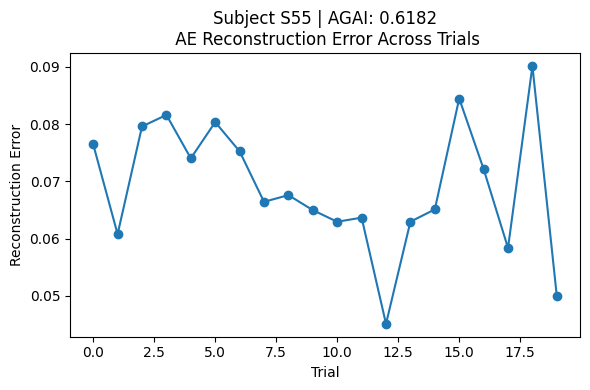

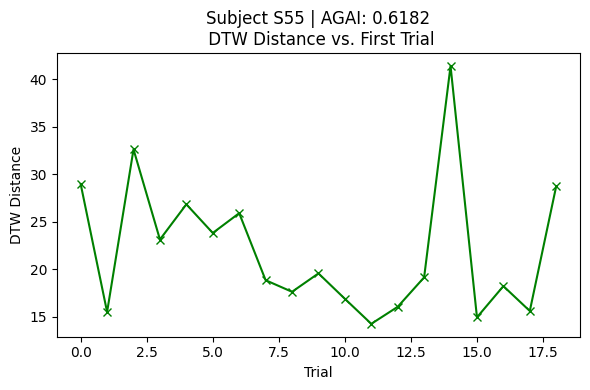

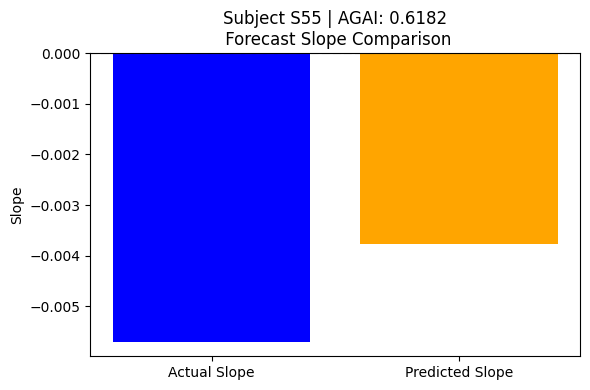

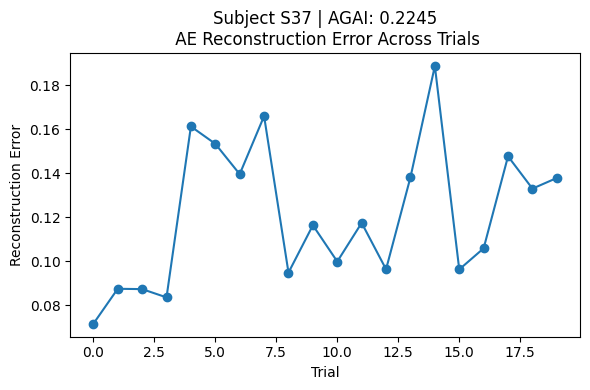

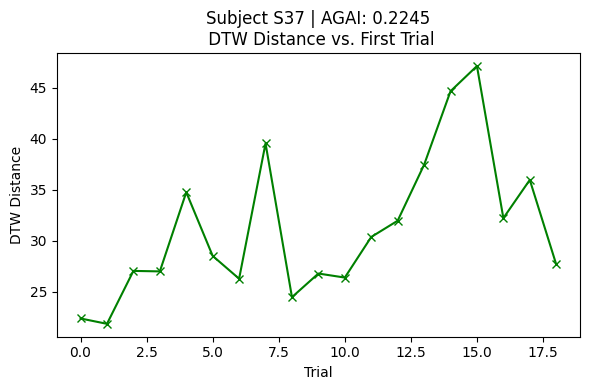

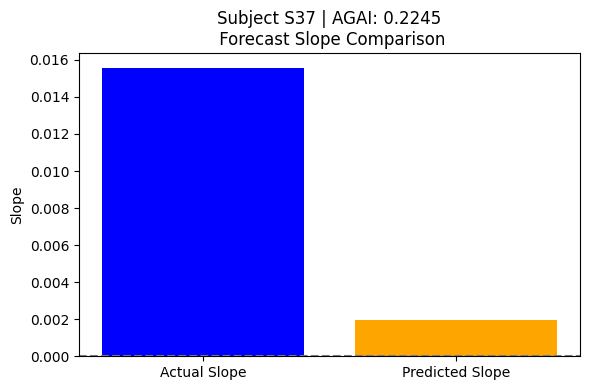

In [ ]:
plot_subject_adaptation_components("S55", subject_data["S55"], agai_score=0.6182)
plot_subject_adaptation_components("S37", subject_data["S37"], agai_score=0.2245)

In [ ]:
all_llm_results = {}

for sid in agai:
    subject_info = subject_data[sid]
    agai_score = agai.get(sid, 0)

    prompt = generate_llm_prompt_narrative(sid, subject_info, agai_score)
    response = call_llm_api(prompt)

    all_llm_results[sid] = {
        "prompt": prompt,
        "response": response,
        "agai_score": round(agai_score, 4)
    }

    print(f"📋 Subject {sid} (AGAI: {round(agai_score, 4)}) LLM adaptation summary:\n{response}\n{'-'*80}")

📋 Subject S02 (AGAI: 0.5229) LLM adaptation summary:
The subject's short-term motor adaptation profile, as indicated by the Acute Gait Adaptation Index (AGAI), suggests a moderate level of variability or adaptation across the 20 trials. The AGAI value reflects a balance between stability and adaptation, with a slight inclination towards variability.

The Autoencoder model reveals some fluctuations in reconstruction errors across trials, with a notable peak in error at trial 8, indicating a temporary increase in variability. However, the overall change from the first to the last trial is minimal, suggesting a return to baseline stability by the end of the trials.

The Forecasting Transformer model shows a negligible difference between the real and predicted slopes of gait feature evolution, indicating a high level of consistency and stability in the subject's gait pattern over time. This model contributes significantly to the interpretation of stability in the subject's motor adaptation

In [ ]:
import pandas as pd

def extract_llm_narrative_and_agai(llm_results, agai_scores):
    extracted = []

    for sid, result in llm_results.items():
        response = result["response"]

        # Get AGAI score
        agai_score = agai_scores.get(sid, None)

        extracted.append({
            "subject_id": sid,
            "agai_score": round(agai_score, 4) if agai_score is not None else None,
            "llm_narrative": response
        })

    # Return a neatly formatted DataFrame
    return pd.DataFrame(extracted)

In [ ]:
df_llm_cleaned = extract_llm_narrative_and_agai(all_llm_results,agai)

In [ ]:
df_llm_cleaned

subject_id  agai_score                                      llm_narrative
0         S02      0.5229  The subject's short-term motor adaptation prof...
1         S03      0.5109  The subject's short-term motor adaptation prof...
2         S04      0.3053  The subject's short-term motor adaptation prof...
3         S05      0.3646  The subject's short-term motor adaptation prof...
4         S06      0.3235  The subject's short-term motor adaptation prof...
5         S07      0.3052  The subject's short-term motor adaptation prof...
6         S08      0.4349  The subject's short-term motor adaptation prof...
7         S09      0.6973  The subject's short-term motor adaptation prof...
8         S10      0.3861  The subject's short-term motor adaptation prof...
9         S11      0.4296  The subject's short-term motor adaptation prof...
10        S12      0.2748  The subject's short-term motor adaptation prof...
11        S13      0.5205  The subject's short-term motor adaptation prof...
12        S14      0.4311  The subject's short-term motor adaptation prof...
13        S15      0.6019  The subject's short-term motor adaptation prof...
14        S16      0.3987  The subject's short-term motor adaptation prof...
15        S17      0.6141  The subject's short-term motor adaptation prof...
16        S18      0.3227  The subject's short-term motor adaptation prof...
17        S19      0.3799  The subject's short-term motor adaptation prof...
18         S1      0.3959  The subject's short-term motor adaptation prof...
19        S20      0.3742  The subject's short-term motor adaptation prof...
20        S21      0.6175  The subject's short-term motor adaptation prof...
21        S22      0.5046  The subject's short-term motor adaptation prof...
22        S23      0.5867  The subject's short-term motor adaptation prof...
23        S24      0.3951  The subject's short-term motor adaptation prof...
24        S25      0.5812  The subject's short-term motor adaptation prof...
25        S26      0.4322  The subject's short-term motor adaptation prof...
26        S27      0.5402  The subject's short-term motor adaptation prof...
27        S28      0.4185  The subject's short-term motor adaptation prof...
28        S29      0.4152  The subject's short-term motor adaptation prof...
29        S30      0.5247  The subject's short-term motor adaptation prof...
30        S31      0.5321  The subject's short-term motor adaptation prof...
31        S32      0.4622  The subject's short-term motor adaptation prof...
32        S33      0.5234  The subject's short-term motor adaptation prof...
33        S34      0.2642  The subject's short-term motor adaptation prof...
34        S35      0.5081  The subject's short-term motor adaptation prof...
35        S36      0.4578  The subject's short-term motor adaptation prof...
36        S37      0.2245  The subject's short-term motor adaptation prof...
37        S38      0.4441  The subject's short-term motor adaptation prof...
38        S39      0.3618  The subject's short-term motor adaptation prof...
39        S40      0.3676  The subject's short-term motor adaptation prof...
40        S41      0.4932  The subject's short-term motor adaptation prof...
41        S42      0.5045  The subject's short-term motor adaptation prof...
42        S43      0.6067  The subject's short-term motor adaptation prof...
43        S44      0.4626  The subject's short-term motor adaptation prof...
44        S45      0.5136  The subject's short-term motor adaptation prof...
45        S46      0.3943  The subject's short-term motor adaptation prof...
46        S47      0.3739  The subject's short-term motor adaptation prof...
47        S48      0.4185  The subject's short-term motor adaptation prof...
48        S49      0.3157  The subject's short-term motor adaptation prof...
49        S50      0.4951  The subject's short-term motor adaptation prof...
50        S51      0.4284  The subject's short-term motor adaptation prof...

In [ ]:
df_llm_cleaned.to_csv("llm_classification_agai.csv")

# Results Interpretation

In [ ]:
import pandas as pd

def classify_agai(score, high=0.6, moderate=0.4):
    if score >= high:
        return "High Adaptation"
    elif score >= moderate:
        return "Moderate Adaptation"
    else:
        return "Low Adaptation"

def build_llm_narrative_agai_df(agai, all_llm_results):
    extracted = []
    for sid, score in agai.items():
        narrative = all_llm_results.get(sid, {}).get("response", "")
        extracted.append({
            "subject_id": sid,
            "agai_score": round(score, 4),
            "agai_category": classify_agai(score),
            "llm_narrative": narrative
        })
    return pd.DataFrame(extracted)

# Create the DataFrame
df_llm_narrative = build_llm_narrative_agai_df(agai, all_llm_results)

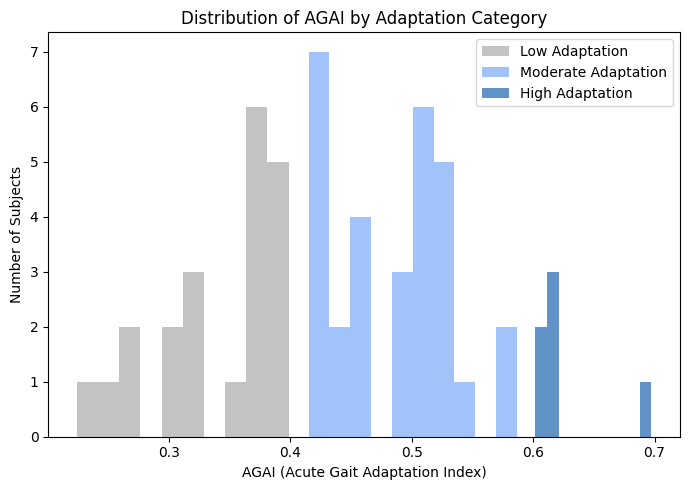

agai_category
Moderate Adaptation    30
Low Adaptation         21
High Adaptation         6
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# Plot AGAI distribution by category
plt.figure(figsize=(7, 5))
for cat, color in zip(["Low Adaptation", "Moderate Adaptation", "High Adaptation"], ["#aaa", "#7baaf7", "#2066ae"]):
    subset = df_llm_narrative[df_llm_narrative["agai_category"] == cat]
    plt.hist(subset["agai_score"], bins=10, alpha=0.7, label=cat, color=color)
plt.xlabel("AGAI (Acute Gait Adaptation Index)")
plt.ylabel("Number of Subjects")
plt.title("Distribution of AGAI by Adaptation Category")
plt.legend()
plt.tight_layout()
plt.show()

# Show counts
print(df_llm_narrative["agai_category"].value_counts())

In [ ]:
# Pick top (highest), median, and lowest AGAI per category (if available)
examples = []
for cat in ["High Adaptation", "Moderate Adaptation", "Low Adaptation"]:
    group = df_llm_narrative[df_llm_narrative["agai_category"] == cat]
    if not group.empty:
        # Highest
        ex_high = group.loc[group["agai_score"].idxmax()]
        # Median
        ex_median = group.iloc[len(group)//2]
        # Lowest
        ex_low = group.loc[group["agai_score"].idxmin()]
        examples += [ex_high, ex_median, ex_low]

examples_df = pd.DataFrame(examples).drop_duplicates("subject_id")
pd.set_option('display.max_colwidth', 200)
print(examples_df[["subject_id", "agai_score", "agai_category", "llm_narrative"]])

   subject_id  agai_score        agai_category  \
7         S09      0.6973      High Adaptation   
20        S21      0.6175      High Adaptation   
13        S15      0.6019      High Adaptation   
22        S23      0.5867  Moderate Adaptation   
31        S32      0.4622  Moderate Adaptation   
28        S29      0.4152  Moderate Adaptation   
14        S16      0.3987       Low Adaptation   
19        S20      0.3742       Low Adaptation   
36        S37      0.2245       Low Adaptation   

                                                                                                                                                                                              llm_narrative  
7   The subject's short-term motor adaptation profile, as indicated by the Acute Gait Adaptation Index (AGAI), suggests a moderate level of variability or adaptation across the 20 trials. The AGAI val...  
20  The subject's short-term motor adaptation profile, as indicated by the Acute Gait A

## Clustering

                     agai_score  ae_delta  forecast_gap  dtw_final_distance
cluster_label                                                              
High Adaptation           0.529     0.009         0.001              12.469
Low Adaptation            0.359    -0.008         0.011              32.437
Moderate Adaptation       0.451    -0.009         0.002              14.857


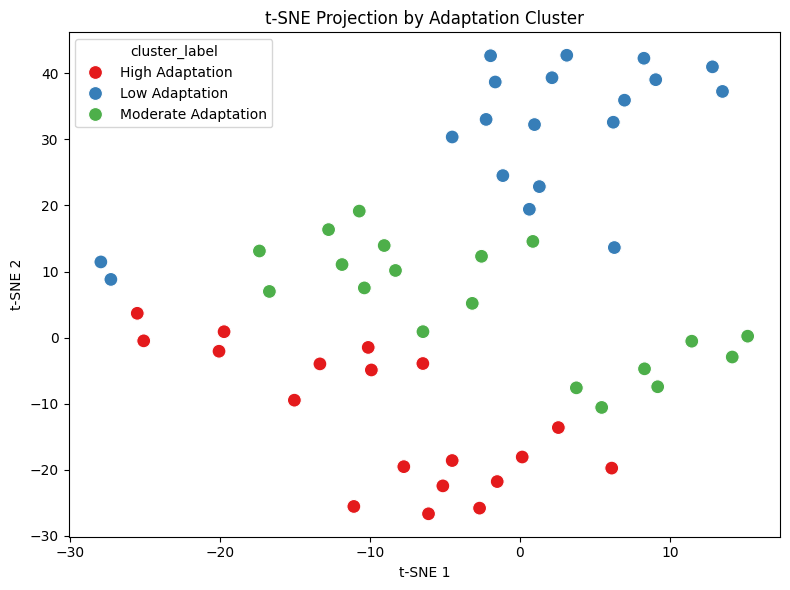


=== Example for Low Adaptation ===
Subject: S04
AGAI: 0.3053
Narrative:
The subject's short-term motor adaptation profile, as indicated by the Acute Gait Adaptation Index (AGAI), suggests a moderate level of variability and adaptation across the 20 trials. The AGAI value reflects a balance of changes in movement reconstruction error, trajectory similarity, and predictio...


=== Example for Moderate Adaptation ===
Subject: S05
AGAI: 0.3646
Narrative:
The subject's short-term motor adaptation profile, as indicated by the Acute Gait Adaptation Index (AGAI), suggests a moderate level of variability or adaptation across the 20 trials. The AGAI value reflects a composite measure of changes in movement patterns, with contributions from autoencoder err...


=== Example for High Adaptation ===
Subject: S02
AGAI: 0.5229
Narrative:
The subject's short-term motor adaptation profile, as indicated by the Acute Gait Adaptation Index (AGAI), suggests a moderate level of variability or adaptation acr

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Merge subject features (agai_score, AE delta, forecast gap, DTW final)
additional_data = []
for sid in df_llm_narrative['subject_id']:
    data = subject_data.get(sid, {})
    ae = data.get('autoencoder', {})
    forecast = data.get('forecasting', {})
    dtw = data.get('dtw', {})

    additional_data.append({
        'subject_id': sid,
        'ae_delta': ae.get('ae_delta', 0),
        'forecast_real_slope': forecast.get('real_slope', 0),
        'forecast_pred_slope': forecast.get('pred_slope', 0),
        'dtw_final_distance': dtw.get('final_dtw', 0),
    })

additional_df = pd.DataFrame(additional_data)
merged_df = df_llm_narrative.merge(additional_df, on='subject_id')
merged_df['forecast_gap'] = abs(merged_df['forecast_real_slope'] - merged_df['forecast_pred_slope'])

# Feature matrix for clustering and DR
features = merged_df[['agai_score', 'ae_delta', 'forecast_gap', 'dtw_final_distance']].fillna(0)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(features_scaled)
merged_df['pca_1'] = pca_result[:, 0]
merged_df['pca_2'] = pca_result[:, 1]

# t-SNE (optionally, use PCA output as input to t-SNE for stability)
tsne = TSNE(n_components=2, random_state=42, perplexity=10, init='pca')
tsne_result = tsne.fit_transform(features_scaled)
merged_df['tsne_1'] = tsne_result[:, 0]
merged_df['tsne_2'] = tsne_result[:, 1]

# KMeans clustering (e.g., 3 clusters for "Low", "Moderate", "High Adaptation")
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(features_scaled)

# Assign interpretable cluster labels by mean AGAI
cluster_means = merged_df.groupby('cluster')['agai_score'].mean().sort_values()
label_map = {cluster: label for cluster, label in zip(cluster_means.index, ['Low Adaptation', 'Moderate Adaptation', 'High Adaptation'])}
merged_df['cluster_label'] = merged_df['cluster'].map(label_map)

# Overview: feature means per cluster
final_profiles = merged_df.groupby('cluster_label')[['agai_score', 'ae_delta', 'forecast_gap', 'dtw_final_distance']].mean().round(3)
print(final_profiles)

# Visualize with Cluster Labels
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='tsne_1', y='tsne_2', hue='cluster_label', palette='Set1', s=100)
plt.title('t-SNE Projection by Adaptation Cluster')
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.tight_layout()
plt.show()

# Show example narratives for each cluster
for label in ['Low Adaptation', 'Moderate Adaptation', 'High Adaptation']:
    print(f"\n=== Example for {label} ===")
    ex = merged_df[merged_df['cluster_label'] == label].iloc[0]
    print(f"Subject: {ex['subject_id']}\nAGAI: {ex['agai_score']}\nNarrative:\n{ex['llm_narrative'][:300]}...\n")

In [ ]:
final_profiles.to_csv("cluster_profiles.csv")

### Cluster Profile Comparison

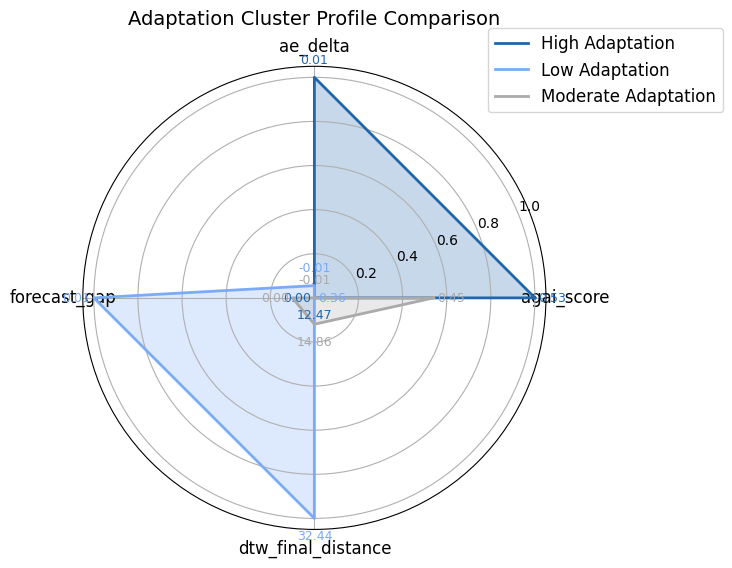

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Normalize for radar chart (each feature min-max across clusters)
normalized_profiles = final_profiles.copy()
for feature in final_profiles.columns:
    min_val = final_profiles[feature].min()
    max_val = final_profiles[feature].max()
    normalized_profiles[feature] = (
        (final_profiles[feature] - min_val) / (max_val - min_val) if max_val != min_val else 0
    )

# Radar chart setup
labels = list(final_profiles.columns)
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
colors = ['#2066ae', '#7baaf7', '#aaa']  # You can tweak colors for each cluster

for idx, (cluster, row) in enumerate(normalized_profiles.iterrows()):
    values = row.tolist()
    values += values[:1]
    ax.plot(angles, values, color=colors[idx % len(colors)], linewidth=2, label=cluster)
    ax.fill(angles, values, color=colors[idx % len(colors)], alpha=0.25)

    # Add raw numerical values to each vertex
    for angle, value, raw_value in zip(angles, values, final_profiles.loc[cluster, labels]):
        ax.text(angle, value + 0.08, f"{raw_value:.2f}", ha='center', va='center', fontsize=9, color=colors[idx % len(colors)])

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=12)
ax.set_title('Adaptation Cluster Profile Comparison', size=14, pad=30)
ax.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1), fontsize=12)
plt.tight_layout()
plt.show()

## Dendogram

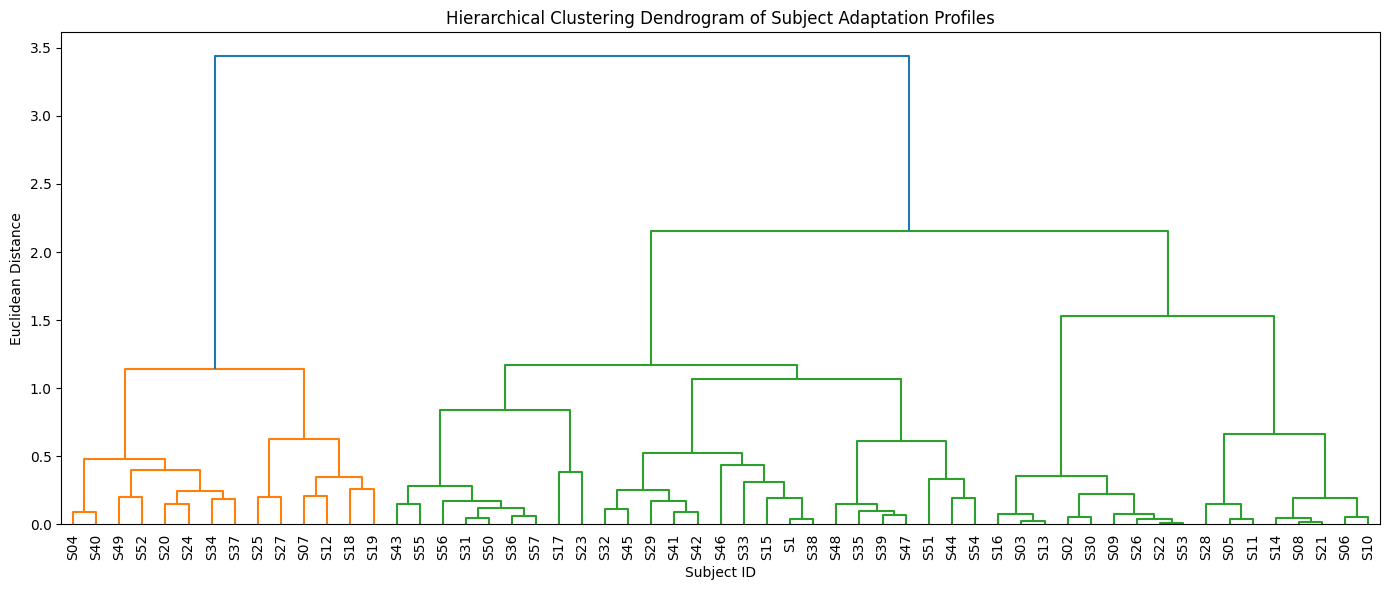

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Step 1: Build subject-level DataFrame
rows = []
for subject_id, data in subject_data.items():
    ae_delta = data["autoencoder"].get("ae_delta")
    real_slope = data["forecasting"].get("real_slope")
    pred_slope = data["forecasting"].get("pred_slope")
    final_dtw = data["dtw"].get("final_dtw")

    # Ensure valid numeric values
    if None not in (ae_delta, real_slope, pred_slope, final_dtw):
        slope_gap = abs(real_slope - pred_slope)
        rows.append({
            "subject_id": subject_id,
            "ae_delta": ae_delta,
            "forecast_gap": slope_gap,
            "dtw_final_distance": final_dtw
        })

# Create DataFrame
subject_profiles_df = pd.DataFrame(rows).set_index("subject_id")

# Step 2: Normalize features (min-max)
normalized_df = (subject_profiles_df - subject_profiles_df.min()) / (subject_profiles_df.max() - subject_profiles_df.min())

# Step 3: Perform hierarchical clustering using Ward linkage
linked = linkage(normalized_df, method='ward')

# Step 4: Plot dendrogram
plt.figure(figsize=(14, 6))
dendrogram(
    linked,
    labels=normalized_df.index.tolist(),
    leaf_rotation=90,
    leaf_font_size=10,
    color_threshold=None
)
plt.title("Hierarchical Clustering Dendrogram of Subject Adaptation Profiles")
plt.xlabel("Subject ID")
plt.ylabel("Euclidean Distance")
plt.tight_layout()
plt.show()

# Ablation Study

DEBUG: name is 'agai_score + ae_delta + forecast_gap + dtw_final_distance'

Ablation: agai_score + ae_delta + forecast_gap + dtw_final_distance
                                                                          agai_score  \
ablation_label_agai_score + ae_delta + forecast_gap + dtw_final_distance               
High                                                                           0.529   
Low                                                                            0.359   
Moderate                                                                       0.451   

                                                                          ae_delta  \
ablation_label_agai_score + ae_delta + forecast_gap + dtw_final_distance             
High                                                                         0.009   
Low                                                                         -0.008   
Moderate                                                               

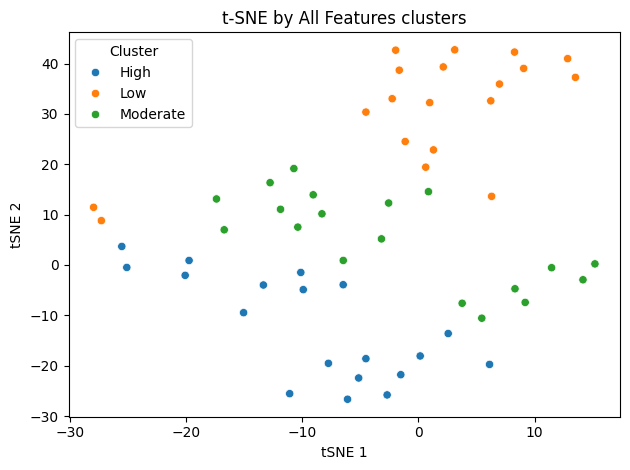

DEBUG: name is 'ae_delta + forecast_gap'

Ablation: ae_delta + forecast_gap
                                        ae_delta  forecast_gap
ablation_label_ae_delta + forecast_gap                        
High                                       0.009         0.001
Low                                       -0.007         0.010
Moderate                                  -0.010         0.002


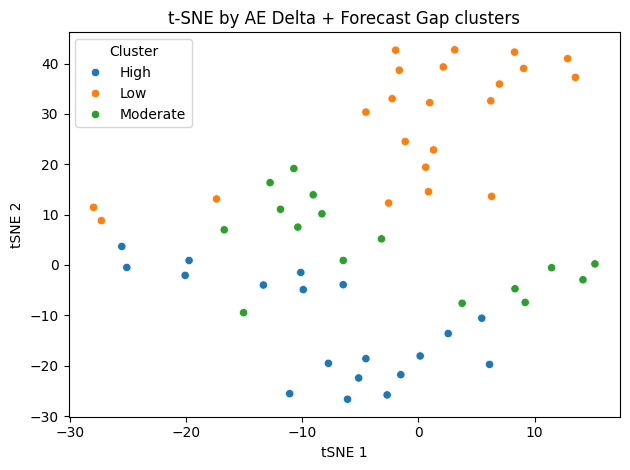

DEBUG: name is 'agai_score + ae_delta + dtw_final_distance'

Ablation: agai_score + ae_delta + dtw_final_distance
                                                           agai_score  \
ablation_label_agai_score + ae_delta + dtw_final_distance               
High                                                            0.511   
Low                                                             0.357   
Moderate                                                        0.442   

                                                           ae_delta  \
ablation_label_agai_score + ae_delta + dtw_final_distance             
High                                                          0.008   
Low                                                          -0.010   
Moderate                                                     -0.008   

                                                           dtw_final_distance  
ablation_label_agai_score + ae_delta + dtw_final_distance                      
High

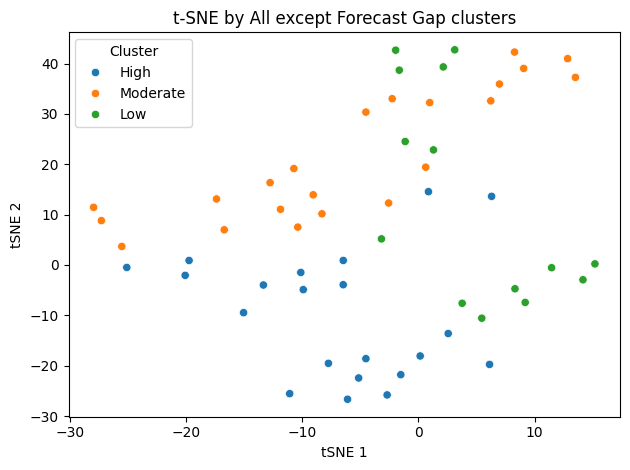

DEBUG: name is 'agai_score + forecast_gap + dtw_final_distance'

Ablation: agai_score + forecast_gap + dtw_final_distance
                                                               agai_score  \
ablation_label_agai_score + forecast_gap + dtw_final_distance               
High                                                                0.522   
Low                                                                 0.335   
Moderate                                                            0.465   

                                                               forecast_gap  \
ablation_label_agai_score + forecast_gap + dtw_final_distance                 
High                                                                  0.003   
Low                                                                   0.011   
Moderate                                                              0.001   

                                                               dtw_final_distance  
ablation_lab

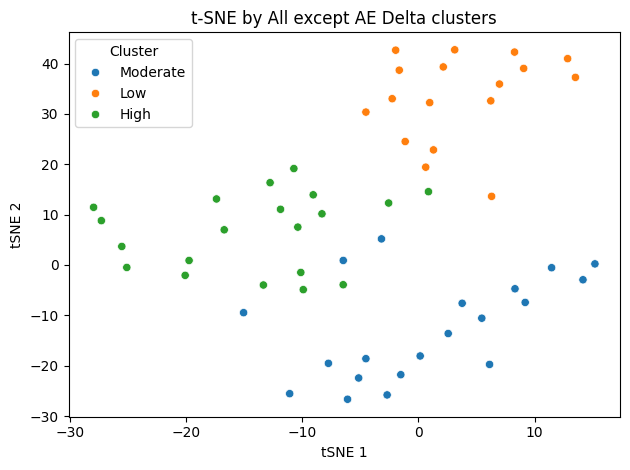

DEBUG: name is 'ae_delta'

Ablation: ae_delta
                         ae_delta
ablation_label_ae_delta          
High                        0.014
Low                        -0.011
Moderate                    0.001


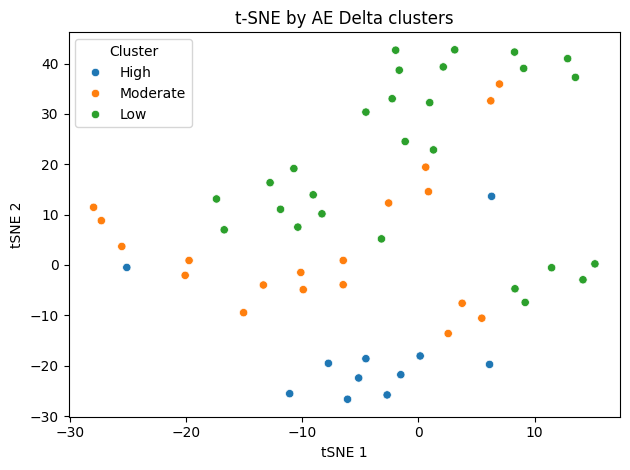

DEBUG: name is 'forecast_gap'

Ablation: forecast_gap
                             forecast_gap
ablation_label_forecast_gap              
High                                0.001
Low                                 0.012
Moderate                            0.006


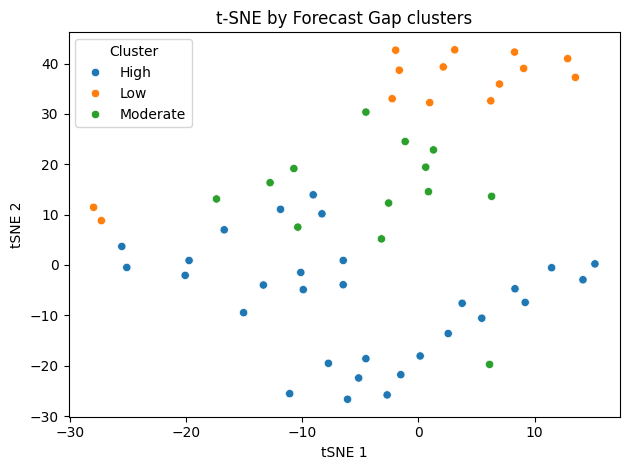

DEBUG: name is 'dtw_final_distance'

Ablation: dtw_final_distance
                                   dtw_final_distance
ablation_label_dtw_final_distance                    
High                                            0.650
Low                                            22.747
Moderate                                       49.042


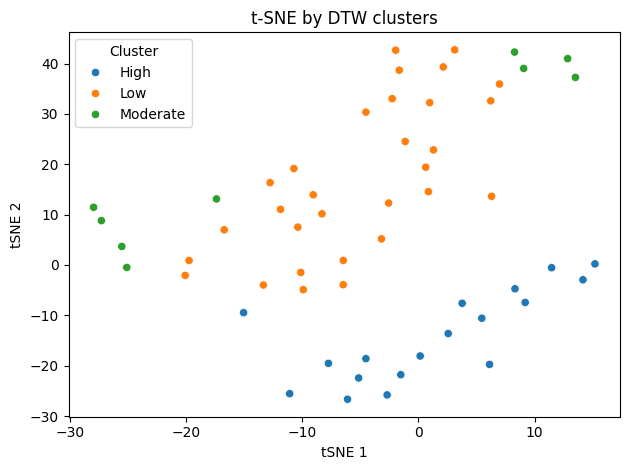

In [ ]:
from sklearn.cluster import KMeans

features_list = [
    ["agai_score", "ae_delta", "forecast_gap", "dtw_final_distance"],  # Full AGAI
    ["ae_delta", "forecast_gap"],       # No DTW
    ["agai_score", "ae_delta", "dtw_final_distance"],  # No forecast gap
    ["agai_score", "forecast_gap", "dtw_final_distance"],    # No AE delta
    ["ae_delta"],   # Only AE delta
    ["forecast_gap"],     # Only forecast gap
    ["dtw_final_distance"] # Only DTW
]

ablation_names = {
    "agai_score + ae_delta + forecast_gap + dtw_final_distance": "All Features",
    "ae_delta + forecast_gap": "AE Delta + Forecast Gap",
    "agai_score + ae_delta + dtw_final_distance": "All except Forecast Gap",
    "agai_score + forecast_gap + dtw_final_distance": "All except AE Delta",
    "ae_delta": "AE Delta",
    "forecast_gap": "Forecast Gap",
    "dtw_final_distance": "DTW"
}

ablation_results = {}

for features in features_list:
    name = " + ".join(features)
    print(f"DEBUG: name is '{name}'")  # See exactly what it is!
    clean_title = ablation_names.get(name, name)  # fallback to name if not found
    X = merged_df[features].fillna(0)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Cluster subjects into 3 groups for comparison
    kmeans = KMeans(n_clusters=3, random_state=42)
    clusters = kmeans.fit_predict(X_scaled)

    merged_df[f"cluster_{name}"] = clusters
    # Order cluster labels by mean agai_score (for consistency)
    cluster_means = merged_df.groupby(f"cluster_{name}")["agai_score"].mean().sort_values()
    label_map = {cluster: label for cluster, label in zip(cluster_means.index, ['Low', 'Moderate', 'High'])}
    merged_df[f"ablation_label_{name}"] = merged_df[f"cluster_{name}"].map(label_map)

    ablation_results[name] = merged_df[f"ablation_label_{name}"]

    # Print/Save cluster means for each ablation
    print(f"\nAblation: {name}")
    print(merged_df.groupby(f"ablation_label_{name}")[features].mean().round(3))

    # Visualize t-SNE or PCA
    #print(f"Plot title: t-SNE by {clean_title} clusters")
    sns.scatterplot(
        x=merged_df['tsne_1'],
        y=merged_df['tsne_2'],
        hue=merged_df[f"ablation_label_{name}"]
    ).set_ylabel("tSNE 2")
    plt.title(f't-SNE by {clean_title} clusters')
    plt.xlabel("tSNE 1")
    plt.legend(title="Cluster")
    plt.tight_layout()
    plt.show()


## Entropy

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import entropy

classic_metrics = []

for sid in df_llm_narrative['subject_id']:
    data = subject_data.get(sid, {})
    ae = data.get('autoencoder', {})
    dtw = data.get('dtw', {})

    rec_errors = np.array(ae.get('reconstruction_error', []))
    dtw_curve = np.array(dtw.get('dtw_curve', []))

    # Standard Deviation
    ae_sd = np.std(rec_errors) if rec_errors.size > 0 else np.nan
    dtw_sd = np.std(dtw_curve) if dtw_curve.size > 0 else np.nan

    # Entropy (discretize to 5 bins)
    def sequence_entropy(seq):
        if len(seq) == 0:
            return np.nan
        counts, _ = np.histogram(seq, bins=5)
        probs = counts / counts.sum() if counts.sum() > 0 else np.zeros_like(counts, dtype=float)
        return entropy(probs, base=2) if probs.sum() > 0 else 0

    ae_entropy = sequence_entropy(rec_errors)
    dtw_entropy = sequence_entropy(dtw_curve)

    # mean/aggregate across features
    features_sd = np.nanmean([ae_sd, dtw_sd])
    features_entropy = np.nanmean([ae_entropy, dtw_entropy])

    classic_metrics.append({
        'subject_id': sid,
        'ae_sd': ae_sd,
        'dtw_sd': dtw_sd,
        'classic_sd': features_sd,
        'ae_entropy': ae_entropy,
        'dtw_entropy': dtw_entropy,
        'classic_entropy': features_entropy
    })

classic_metrics_df = pd.DataFrame(classic_metrics)

In [ ]:
classic_metrics_df

subject_id     ae_sd     dtw_sd  classic_sd  ae_entropy  dtw_entropy  \
0         S02  0.028617   0.000000    0.014308    1.710777     0.000000   
1         S03  0.032442   0.000000    0.016221    2.044557     0.000000   
2         S04  0.058780  10.347366    5.203073    1.188376     1.700224   
3         S05  0.029083   0.000000    0.014541    1.935946     0.000000   
4         S06  0.032711   0.000000    0.016355    2.089245     0.000000   
5         S07  0.037477   9.629212    4.833344    2.201609     2.233998   
6         S08  0.029737   0.000000    0.014868    1.845463     0.000000   
7         S09  0.039630   0.000000    0.019815    2.058053     0.000000   
8         S10  0.025130   0.000000    0.012565    2.284476     0.000000   
9         S11  0.034236   0.000000    0.017118    1.952683     0.000000   
10        S12  0.059403   8.070957    4.065180    1.785475     2.076289   
11        S13  0.113522   0.000000    0.056761    0.548954     0.000000   
12        S14  0.073084   0.000000    0.036542    1.220729     0.000000   
13        S15  0.025987  11.952108    5.989048    2.270951     1.924824   
14        S16  0.025025   0.000000    0.012513    1.786301     0.000000   
15        S17  0.047599  15.821206    7.934402    1.188376     1.952683   
16        S18  0.069112  10.634502    5.351807    1.543752     1.824817   
17        S19  0.057934   8.366409    4.212172    1.821928     2.102091   
18         S1  0.026292   7.050029    3.538161    1.695462     1.886308   
19        S20  0.029048  12.137200    6.083124    2.088376     2.249287   
20        S21  0.086711   0.000000    0.043356    1.625379     0.000000   
21        S22  0.025208   0.000000    0.012604    2.004748     0.000000   
22        S23  0.024839   8.715014    4.369926    2.041446     2.149280   
23        S24  0.021142  10.078895    5.050018    2.195462     2.018216   
24        S25  0.030935  12.722367    6.376651    1.946439     2.249287   
25        S26  0.027088   0.000000    0.013544    1.935946     0.000000   
26        S27  0.152332  13.928733    7.040532    1.291760     2.268473   
27        S28  0.024423   0.000000    0.012211    2.076289     0.000000   
28        S29  0.016211   3.776397    1.896304    2.063865     2.089004   
29        S30  0.016595   0.000000    0.008298    2.057924     0.000000   
30        S31  0.023696   8.509743    4.266719    1.578390     1.613520   
31        S32  0.021253   3.929883    1.975568    2.126121     2.168466   
32        S33  0.034896   9.512042    4.773469    1.977235     2.249287   
33        S34  0.013491   5.782933    2.898212    2.303702     2.076289   
34        S35  0.032731   3.880305    1.956518    1.919973     2.041815   
35        S36  0.009783   7.303825    3.656804    2.252724     1.885093   
36        S37  0.031424   6.928587    3.480005    2.228213     2.154536   
37        S38  0.018231   5.639562    2.828897    1.436666     2.214812   
38        S39  0.014930   7.193281    3.604106    2.041446     1.562688   
39        S40  0.034216   7.272416    3.653316    1.719973     2.041815   
40        S41  0.015690   8.264082    4.139886    1.946439     1.323532   
41        S42  0.017272  10.787941    5.402607    2.088376     1.465790   
42        S43  0.017148   4.290869    2.154008    2.133206     2.186809   
43        S44  0.018309   4.142686    2.080498    1.336160     2.018216   
44        S45  0.018933   5.628753    2.823843    1.616642     1.758298   
45        S46  0.027220   8.306042    4.166631    1.880482     2.268473   
46        S47  0.017317   4.519468    2.268393    2.303702     1.991571   
47        S48  0.021819   6.186827    3.104323    2.078390     2.102933   
48        S49  0.020946   8.678589    4.349768    1.947731     1.192251   
49        S50  0.022667   5.593900    2.808284    2.041446     2.259799   
50        S51  0.016574   5.871539    2.944056    1.801609     1.885093   
51        S52  0.031326   5.300526    2.665926    1.812888     1.976282   
52        S53  0.010916   0.

In [ ]:
classic_metrics_df.to_csv("classic_metrics.csv")

In [ ]:
df_compare = df_llm_narrative.merge(classic_metrics_df, on='subject_id')

In [ ]:
# Already merged as df_compare
df_compare[["subject_id", "agai_score", "classic_sd", "classic_entropy"]].head()

subject_id  agai_score  classic_sd  classic_entropy
0        S02      0.5229    0.014308         0.855389
1        S03      0.5109    0.016221         1.022278
2        S04      0.3053    5.203073         1.444300
3        S05      0.3646    0.014541         0.967973
4        S06      0.3235    0.016355         1.044622

In [ ]:
df_compare.to_csv("df_compare.csv")

In [ ]:
from scipy.stats import pearsonr

r_sd, p_sd = pearsonr(df_compare['agai_score'], df_compare['classic_sd'])
r_entropy, p_entropy = pearsonr(df_compare['agai_score'], df_compare['classic_entropy'])

print(f"AGAI vs. Classic SD: r = {r_sd:.2f}, p = {p_sd:.4f}")
print(f"AGAI vs. Classic Entropy: r = {r_entropy:.2f}, p = {p_entropy:.4f}")

AGAI vs. Classic SD: r = -0.03, p = 0.8286
AGAI vs. Classic Entropy: r = -0.16, p = 0.2255


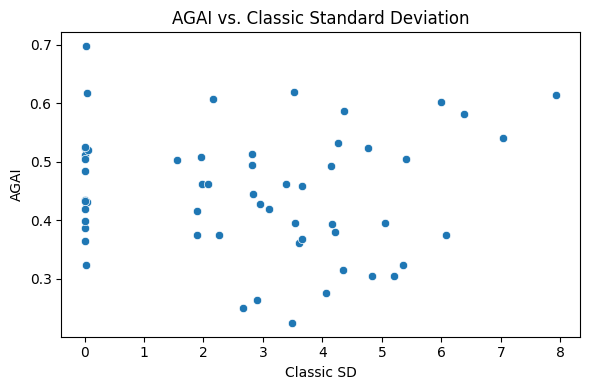

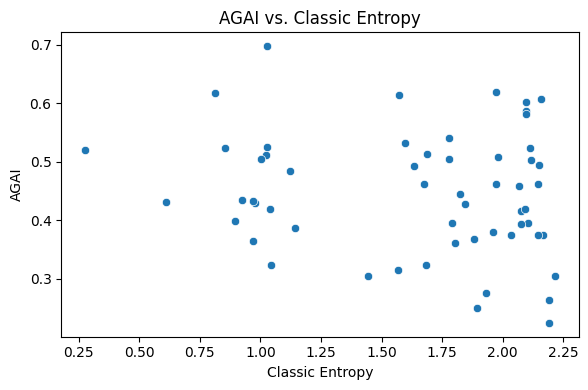

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.scatterplot(x='classic_sd', y='agai_score', data=df_compare)
plt.title("AGAI vs. Classic Standard Deviation")
plt.xlabel("Classic SD")
plt.ylabel("AGAI")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.scatterplot(x='classic_entropy', y='agai_score', data=df_compare)
plt.title("AGAI vs. Classic Entropy")
plt.xlabel("Classic Entropy")
plt.ylabel("AGAI")
plt.tight_layout()
plt.show()


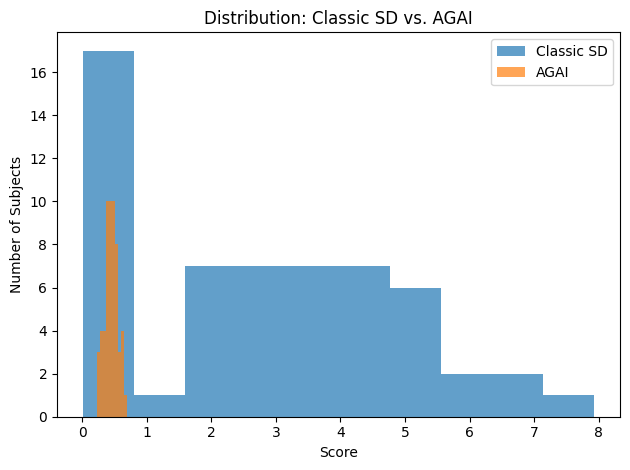

In [ ]:
plt.hist(df_compare['classic_sd'], bins=10, alpha=0.7, label='Classic SD')
plt.hist(df_compare['agai_score'], bins=10, alpha=0.7, label='AGAI')
plt.legend()
plt.xlabel("Score")
plt.ylabel("Number of Subjects")
plt.title("Distribution: Classic SD vs. AGAI")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import KMeans

# Cluster by classic SD
X = df_compare[['classic_sd']].fillna(0)
kmeans = KMeans(n_clusters=3, random_state=42)
df_compare['classic_sd_cluster'] = kmeans.fit_predict(X)

# Map clusters to adaptation categories by mean value
means = df_compare.groupby('classic_sd_cluster')['classic_sd'].mean().sort_values()
cat_map = {cid: label for cid, label in zip(means.index, ['Low Variability', 'Moderate Variability', 'High Variability'])}
df_compare['classic_sd_label'] = df_compare['classic_sd_cluster'].map(cat_map)
pd.crosstab(df_compare['agai_category'], df_compare['classic_sd_label'])

classic_sd_label     High Variability  Low Variability  Moderate Variability
agai_category                                                               
High Adaptation                     2                2                     2
Low Adaptation                      5                4                    12
Moderate Adaptation                 4               12                    14